In [1]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, ReLU, LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers

import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

total_df = pd.read_csv("to_mrmr.csv")

window_n = 5
stride = 12
window_size = 24
normal_scores = []
feature = ['flux',
           'zero_month',
           'zero_week',
           'continuous_zero',
           'diff_week_day',
           'diff_month',
           'std_week',
           'diff_std',
           'rec_day',
           'rec_week',
           'rec_2week',
           'rec_month',
           'rec_day2',
           'rec_week2',
           'rec_2week2',
           'rec_month2', ]


df = total_df.dropna(axis=0)

normal = df[df['label']==0]
abnormal = df[df['label']==1]

#def kl_divergence(p, q):
#  return np.sum(np.where(p != 0, p * np.log(p / (q+1e-8)+1e-8), 0), axis=-1)


#gmm = mixture.GaussianMixture(n_components=15, covariance_type='full')

#X = scale(normal.loc[:, feature].sample(frac=0.2).to_numpy())

#gmm.fit(X)

#normal_prob = gmm.score_samples(X)

#print(normal_prob)

#assert(False)
#normal_kde = stats.gaussian_kde(normal_prob, bw_method='silverman')





total_data = total_df.dropna().loc[:, ['label'] + feature].to_numpy()

where_abnormal = np.argwhere(total_data[:,0]==1)


#assert(False)

good_score = []
bad_score = []
print(normal.shape[0])



normal_data = []

for i in range(0,total_data.shape[0]-(window_size + (window_n-1)*stride )):
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size])
  ws = np.array(ws)
  if np.all(ws[:,:,0] == 0):
    normal_data.append(ws[:, :, 1:])
  #if i == 1000:
  #  break;

normal_data = np.array(normal_data, dtype=np.float32)

print(normal_data.shape)
    
#assert(False)
#good_score.append(kl_divergence(w_p, normal_q))
abnormal_data = []

print(where_abnormal.shape)
for ab in where_abnormal:
  i = ab[0] + 1 - window_size - stride * (window_n-1)
  if (i < 0):
    continue
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size, 1:])
  ws = np.array(ws)
  abnormal_data.append(ws)

abnormal_data = np.array(abnormal_data, dtype=np.float32)


random_idx = np.arange(normal_data.shape[0])
np.random.shuffle(random_idx)
normal_data = normal_data[random_idx]

random_idx = np.arange(abnormal_data.shape[0])
np.random.shuffle(random_idx)
abnormal_data = abnormal_data[random_idx]

cut = normal_data.shape[0]*2//10

training_x = normal_data[:cut]
training_y = [[1, 0] for _ in range(cut)]
duplicate_weight = 200

for _ in range(duplicate_weight):
  training_x = np.concatenate([training_x, abnormal_data[:abnormal_data.shape[0]//2]], axis = 0)
training_y = training_y + [[0, 1] for _ in range(training_x.shape[0]-len(training_y))]

training_y = np.array(training_y)


test_x = normal_data[cut:]
test_y = [[1, 0] for _ in range(normal_data.shape[0]-cut)]

test_x = np.concatenate([test_x, abnormal_data[abnormal_data.shape[0]//2:]], axis = 0)
test_y = test_y + [[0, 1] for _ in range(test_x.shape[0]-len(test_y))]

test_y = np.array(test_y)

print(training_x.shape)
print(training_y.shape)
print(test_x.shape)
print(test_y.shape)

                             

  
def get_data():
    global training_x, training_y
    random_idx = np.arange(training_x.shape[0])
    np.random.shuffle(random_idx)
    training_x = training_x[random_idx]
    training_y = training_y[random_idx]
    for i in range(training_x.shape[0]):
      x = training_x[i].astype(np.float32)
      y = training_y[i].astype(np.int8)
      yield (x, y)

training_set = tf.data.Dataset.from_generator(get_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

training_set = training_set.batch(256)



def get_test_data():
    global test_x, test_y
    for i in range(test_x.shape[0]):
      x = test_x[i].astype(np.float32)
      y = test_y[i].astype(np.int8)
      yield (x, y)

test_set = tf.data.Dataset.from_generator(get_test_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

test_set = test_set.batch(256)

2855614
(2850488, 5, 24, 16)
(978, 1)
(667897, 5, 24, 16)
(667897, 2)
(2280880, 5, 24, 16)
(2280880, 2)


Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.2481 - accuracy: 0.9442
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3010 - accuracy: 0.9309
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2528 - accuracy: 0.9489
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3243 - accuracy: 0.9272
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3328 - accuracy: 0.9098
Epoch 6/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3237 - accuracy: 0.9199
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2568 - accuracy: 0.9564
Epoch 8/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2408 - accuracy: 0.9598
Epoch 9/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2333 - accuracy: 0.9635
Epoch 10/10
1583/1583 [==============================] - 25s 16m

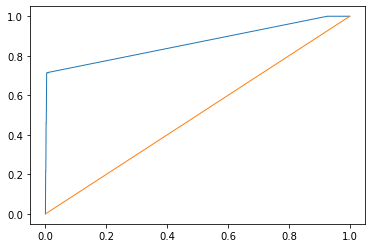

0.8656974991143983


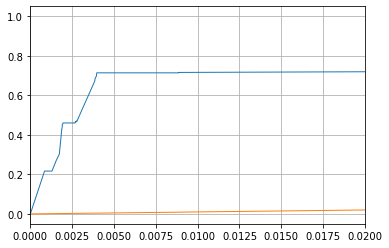

fpr: 0.001300174667093506
tpr:  0.2167689161554192

106 355643 463 383
precision:  0.18629173989455183
recall:  0.2167689161554192
F-measure: 0.2003780718336484
MCC: 0.19977050132992463
Epoch 1/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.2673 - accuracy: 0.9491
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2626 - accuracy: 0.9528
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2600 - accuracy: 0.9586
Epoch 4/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3706 - accuracy: 0.9047
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3213 - accuracy: 0.9345
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2914 - accuracy: 0.9453
Epoch 7/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.2809 - accuracy: 0.9502
Epoch 8/10
1583/1583 [==============================] - 25s 15ms/step - loss: 0.2787 -

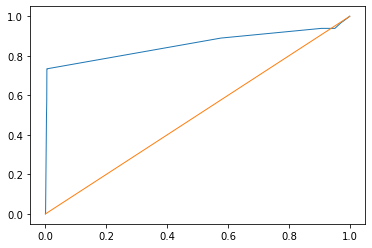

0.8565823103359644


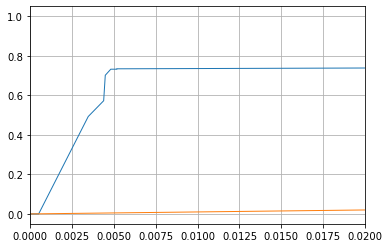

fpr: 0.0034680684964589195
tpr:  0.49284253578732107

241 354871 1235 248
precision:  0.1632791327913279
recall:  0.49284253578732107
F-measure: 0.24529262086513995
MCC: 0.28206892831968305
Epoch 1/10
1583/1583 [==============================] - 31s 20ms/step - loss: 0.2770 - accuracy: 0.9453
Epoch 2/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2642 - accuracy: 0.9535
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2483 - accuracy: 0.9572
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3132 - accuracy: 0.9427
Epoch 5/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3798 - accuracy: 0.9287
Epoch 6/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3118 - accuracy: 0.9578
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3619 - accuracy: 0.9335
Epoch 8/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.33

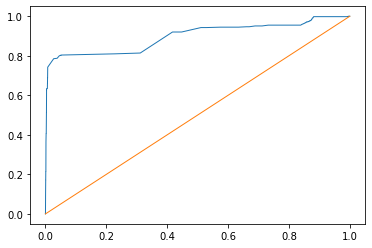

0.8976725405065106


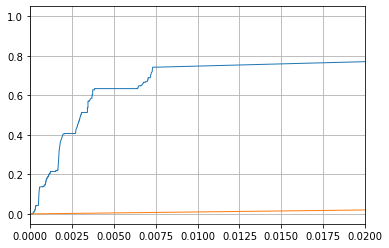

fpr: 0.0010025104884500682
tpr:  0.17791411042944785

87 355749 357 402
precision:  0.19594594594594594
recall:  0.17791411042944785
F-measure: 0.18649517684887462
MCC: 0.18564865885230408
Epoch 1/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.3553 - accuracy: 0.9454
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3819 - accuracy: 0.9488
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.4444 - accuracy: 0.9349
Epoch 4/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.5061 - accuracy: 0.9193
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3639 - accuracy: 0.9551
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3312 - accuracy: 0.9547
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2977 - accuracy: 0.9582
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.356

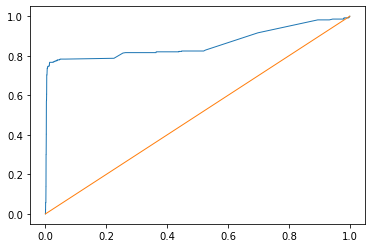

0.860260645720972


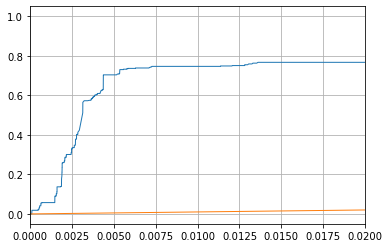

fpr: 0.0010783306094252834
tpr:  0.05725971370143149

28 355722 384 461
precision:  0.06796116504854369
recall:  0.05725971370143149
F-measure: 0.06215316315205328
MCC: 0.06119998278244753


In [2]:
#1층

l2param=0.001

for unit in [32, 64, 128, 256]:
  
  model = Sequential()

  model.add(keras.Input(shape=(window_n, window_size, len(feature))))
  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(units=unit,
                kernel_regularizer=tf.keras.regularizers.l2(l2param)
                ))
  model.add(Dense(2, activation='sigmoid',
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)))

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

  model.fit(training_set, epochs=10, verbose=1)

  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt


  result = model.predict(test_set)[:, 1]

  #plt.figure()
  #plt.plot(result[:100])
  #plt.show()
  new_label = test_y[:,1]
  #new_label = 1-label
  #new_label = label.astype(np.int)

  #print(result[1500:1600])
  #print(new_label[1500:1600])
  print("="*20)
  print("unit: ", unit)
  fpr, tpr, thesholds = roc_curve(new_label, result)
  print(thesholds)
  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()
  print(auc(fpr, tpr))

  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.xlim([0, 0.02])
  plt.grid("on")
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()


  for i in range(len(fpr)):
    if fpr[i] > 0.001: #0.1%
      break;
  print("fpr:", fpr[i])
  print("tpr: ",tpr[i])
  print()
  predicted = result >= thesholds[i]
  TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
  TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
  FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
  FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

  print(TP,TN,FP,FN)

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)

  print("precision: ", Precision)
  print("recall: ", Recall)
  print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
  print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))


Epoch 1/10
1583/1583 [==============================] - 29s 18ms/step - loss: 0.2629 - accuracy: 0.9411
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2474 - accuracy: 0.9492
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2340 - accuracy: 0.9500
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2381 - accuracy: 0.9517
Epoch 5/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2184 - accuracy: 0.9552
Epoch 6/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.2089 - accuracy: 0.9559
Epoch 7/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.2283 - accuracy: 0.9536
Epoch 8/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.3025 - accuracy: 0.9250
Epoch 9/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2346 - accuracy: 0.9544
Epoch 10/10
1583/1583 [==============================] - 26s 17m

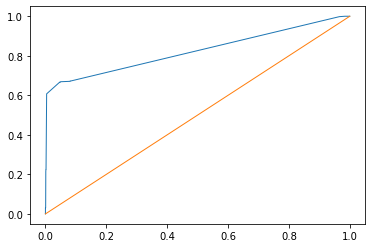

0.8241072225260654


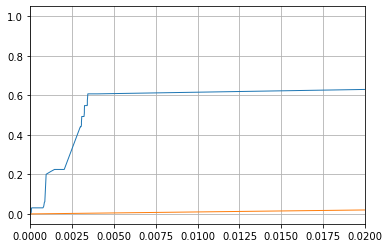

fpr: 0.001229970851375714
tpr:  0.2147239263803681

105 355668 438 384
precision:  0.19337016574585636
recall:  0.2147239263803681
F-measure: 0.20348837209302326
MCC: 0.20261566964018157
Epoch 1/10
1583/1583 [==============================] - 30s 19ms/step - loss: 0.2225 - accuracy: 0.9519
Epoch 2/10
1583/1583 [==============================] - 28s 17ms/step - loss: 0.2393 - accuracy: 0.9501
Epoch 3/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2050 - accuracy: 0.9577
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2303 - accuracy: 0.9515
Epoch 5/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2036 - accuracy: 0.9570
Epoch 6/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2848 - accuracy: 0.9331
Epoch 7/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3152 - accuracy: 0.9230
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2312 

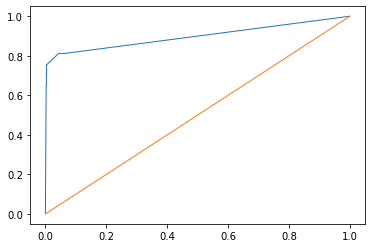

0.897775365408133


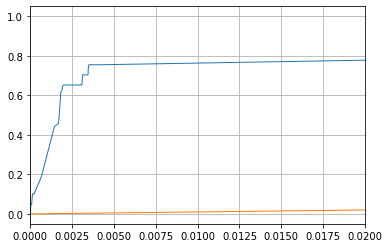

fpr: 0.001446198603786513
tpr:  0.44171779141104295

216 355591 515 273
precision:  0.2954856361149111
recall:  0.44171779141104295
F-measure: 0.3540983606557377
MCC: 0.36021684945651816
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.2289 - accuracy: 0.9514
Epoch 2/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.2523 - accuracy: 0.9431
Epoch 3/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2302 - accuracy: 0.9512
Epoch 4/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.2224 - accuracy: 0.9534
Epoch 5/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.1951 - accuracy: 0.9585
Epoch 6/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2390 - accuracy: 0.9457
Epoch 7/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2338 - accuracy: 0.9498
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2267 

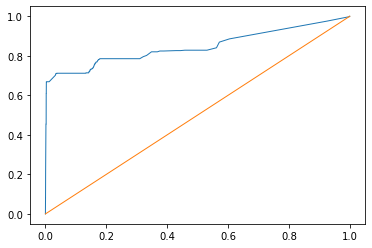

0.8465087317984189


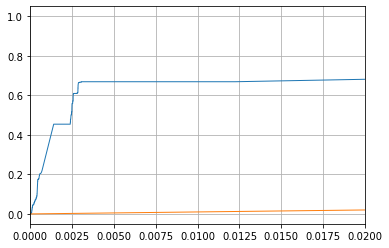

fpr: 0.0014040763143558378
tpr:  0.4539877300613497

222 355606 500 267
precision:  0.3074792243767313
recall:  0.4539877300613497
F-measure: 0.36663914120561514
MCC: 0.37258624765902904
Epoch 1/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.2519 - accuracy: 0.9442
Epoch 2/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2249 - accuracy: 0.9503
Epoch 3/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2289 - accuracy: 0.9537
Epoch 4/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.1943 - accuracy: 0.9602
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3038 - accuracy: 0.9185
Epoch 6/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.3032 - accuracy: 0.9227
Epoch 7/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.2414 - accuracy: 0.9560
Epoch 8/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2674 

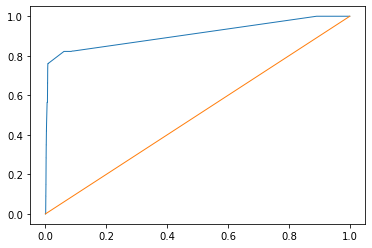

0.9083791679545979


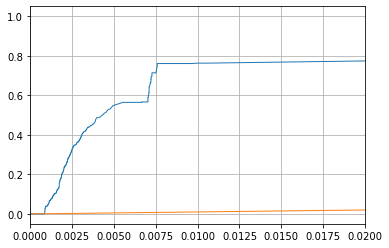

fpr: 0.0010418246252520318
tpr:  0.0408997955010225

20 355735 371 469
precision:  0.05115089514066496
recall:  0.0408997955010225
F-measure: 0.045454545454545456
MCC: 0.044567829692125395
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.2609 - accuracy: 0.9445
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2559 - accuracy: 0.9542
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2239 - accuracy: 0.9544
Epoch 4/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2130 - accuracy: 0.9585
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2617 - accuracy: 0.9462
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2542 - accuracy: 0.9485
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2721 - accuracy: 0.9471
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.302

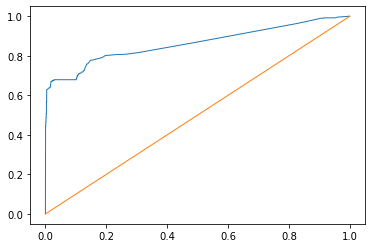

0.8618290305486465


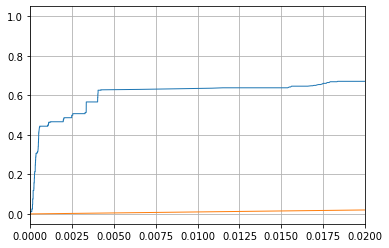

fpr: 0.001013743098964915
tpr:  0.4437627811860941

217 355745 361 272
precision:  0.3754325259515571
recall:  0.4437627811860941
F-measure: 0.4067478912839737
MCC: 0.40728874980877877
Epoch 1/10
1583/1583 [==============================] - 28s 17ms/step - loss: 0.2481 - accuracy: 0.9477
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2637 - accuracy: 0.9503
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2388 - accuracy: 0.9520
Epoch 4/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2538 - accuracy: 0.9491
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2659 - accuracy: 0.9477
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2614 - accuracy: 0.9500
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2241 - accuracy: 0.9572
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2268 - 

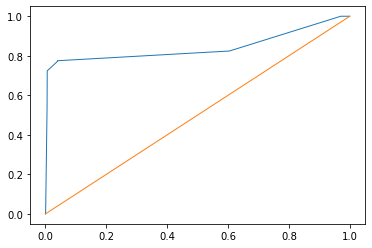

0.8417228931754507


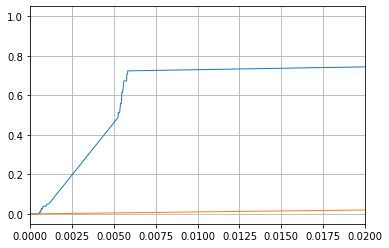

fpr: 0.00100531864107878
tpr:  0.049079754601226995

24 355748 358 465
precision:  0.06282722513089005
recall:  0.049079754601226995
F-measure: 0.05510907003444317
MCC: 0.054384070307079015
Epoch 1/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.2418 - accuracy: 0.9511
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2408 - accuracy: 0.9531
Epoch 3/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2488 - accuracy: 0.9530
Epoch 4/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2367 - accuracy: 0.9535
Epoch 5/10
1583/1583 [==============================] - 24s 15ms/step - loss: 0.2324 - accuracy: 0.9545
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2117 - accuracy: 0.9586
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2276 - accuracy: 0.9559
Epoch 8/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.34

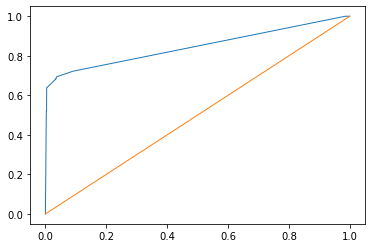

0.846132189541183


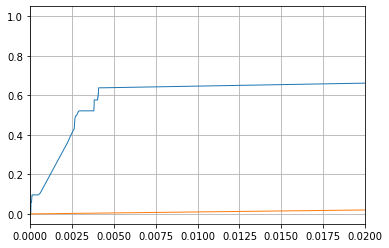

fpr: 0.002224056881939647
tpr:  0.35991820040899797

176 355314 792 313
precision:  0.18181818181818182
recall:  0.35991820040899797
F-measure: 0.24159231297186
MCC: 0.25440220017994014
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.2833 - accuracy: 0.9413
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2417 - accuracy: 0.9523
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2893 - accuracy: 0.9343
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2651 - accuracy: 0.9515
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3875 - accuracy: 0.9056
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.4087 - accuracy: 0.8941
Epoch 7/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.4061 - accuracy: 0.8801
Epoch 8/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3444 -

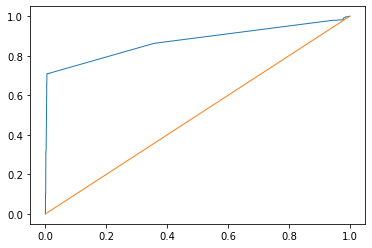

0.8744826524332725


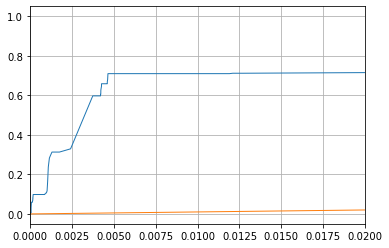

fpr: 0.0010081267937074917
tpr:  0.1165644171779141

57 355747 359 432
precision:  0.13701923076923078
recall:  0.1165644171779141
F-measure: 0.12596685082872927
MCC: 0.12527281779959498
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.2874 - accuracy: 0.9481
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3645 - accuracy: 0.9319
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3646 - accuracy: 0.9351
Epoch 4/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.3351 - accuracy: 0.9432
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2800 - accuracy: 0.9543
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2466 - accuracy: 0.9566
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2597 - accuracy: 0.9555
Epoch 8/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3435 

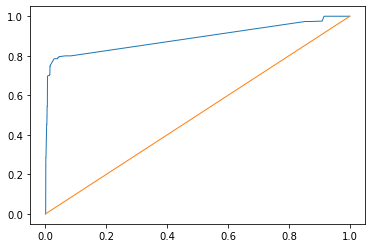

0.8899827361208148


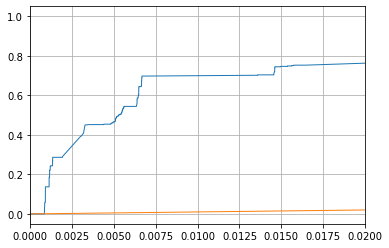

fpr: 0.0011288773567420937
tpr:  0.13701431492842536

67 355704 402 422
precision:  0.14285714285714285
recall:  0.13701431492842536
F-measure: 0.13987473903966596
MCC: 0.1387486384662451
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.3100 - accuracy: 0.9387
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3231 - accuracy: 0.9371
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3212 - accuracy: 0.9390
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3199 - accuracy: 0.9442
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2697 - accuracy: 0.9545
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2677 - accuracy: 0.9536
Epoch 7/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3072 - accuracy: 0.9439
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2749

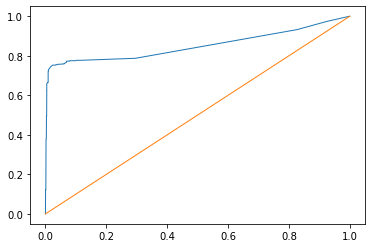

0.8509599121338806


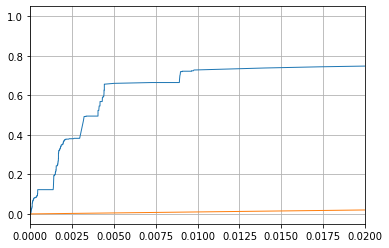

fpr: 0.0010025104884500682
tpr:  0.12269938650306748

60 355749 357 429
precision:  0.14388489208633093
recall:  0.12269938650306748
F-measure: 0.1324503311258278
MCC: 0.13177163423608187
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.2698 - accuracy: 0.9482
Epoch 2/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2836 - accuracy: 0.9523
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.4138 - accuracy: 0.91780s - loss: 0.4162 - 
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2784 - accuracy: 0.9521
Epoch 5/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2626 - accuracy: 0.9516
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.2434 - accuracy: 0.9585
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3491 - accuracy: 0.9349
Epoch 8/10
1583/1583 [==============================] - 25s 16ms

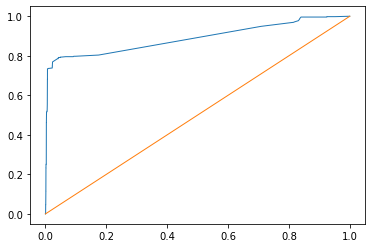

0.8889925034039807


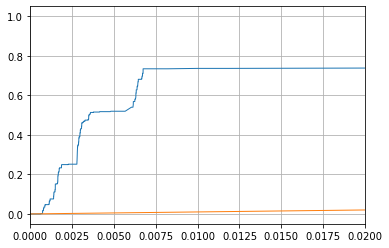

fpr: 0.0011064121357124003
tpr:  0.04703476482617587

23 355712 394 466
precision:  0.05515587529976019
recall:  0.04703476482617587
F-measure: 0.050772626931567325
MCC: 0.0497305624432511
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.3230 - accuracy: 0.9383
Epoch 2/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3404 - accuracy: 0.9430
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.4217 - accuracy: 0.9164
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3208 - accuracy: 0.9491
Epoch 5/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2528 - accuracy: 0.9569
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3317 - accuracy: 0.9415
Epoch 7/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.2524 - accuracy: 0.9574
Epoch 8/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.287

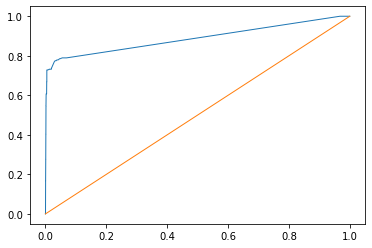

0.8878515463968202


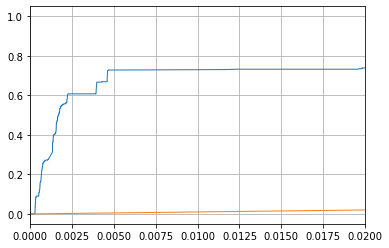

fpr: 0.0010025104884500682
tpr:  0.2719836400817996

133 355749 357 356
precision:  0.2714285714285714
recall:  0.2719836400817996
F-measure: 0.27170582226762
MCC: 0.27070485710580344
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.3438 - accuracy: 0.9445
Epoch 2/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3761 - accuracy: 0.9460
Epoch 3/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.4405 - accuracy: 0.9255
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3422 - accuracy: 0.9518
Epoch 5/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3234 - accuracy: 0.9480
Epoch 6/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3176 - accuracy: 0.9579
Epoch 7/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3825 - accuracy: 0.9394
Epoch 8/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.3322 - a

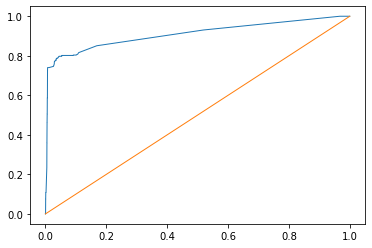

0.9091419776356887


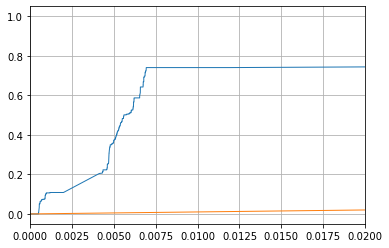

fpr: 0.0011850404093163272
tpr:  0.10633946830265849

52 355684 422 437
precision:  0.10970464135021098
recall:  0.10633946830265849
F-measure: 0.10799584631360332
MCC: 0.10680305539733052
Epoch 1/10
1583/1583 [==============================] - 34s 22ms/step - loss: 0.3457 - accuracy: 0.9476
Epoch 2/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.4171 - accuracy: 0.9325
Epoch 3/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3265 - accuracy: 0.9530
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.4113 - accuracy: 0.9386
Epoch 5/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3950 - accuracy: 0.9393
Epoch 6/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3369 - accuracy: 0.9497
Epoch 7/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.3666 - accuracy: 0.9460
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.383

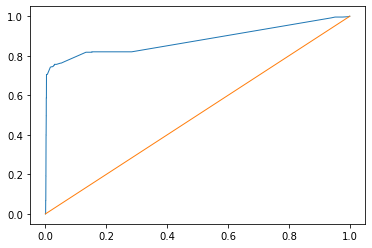

0.8791468187989381


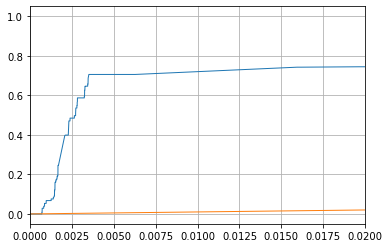

fpr: 0.0010418246252520318
tpr:  0.06748466257668712

33 355735 371 456
precision:  0.08168316831683169
recall:  0.06748466257668712
F-measure: 0.07390817469204927
MCC: 0.07309035911784154
Epoch 1/10
1583/1583 [==============================] - 28s 18ms/step - loss: 0.3815 - accuracy: 0.9350
Epoch 2/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.4152 - accuracy: 0.9372
Epoch 3/10
1583/1583 [==============================] - 25s 16ms/step - loss: 0.4496 - accuracy: 0.9272
Epoch 4/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3497 - accuracy: 0.9483
Epoch 5/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.3609 - accuracy: 0.9458
Epoch 6/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.3260 - accuracy: 0.9517
Epoch 7/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.3460 - accuracy: 0.9501
Epoch 8/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.416

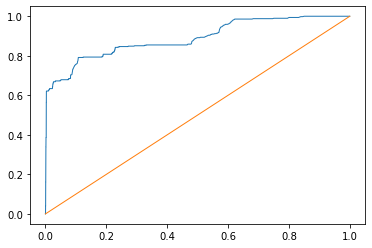

0.8893886567884701


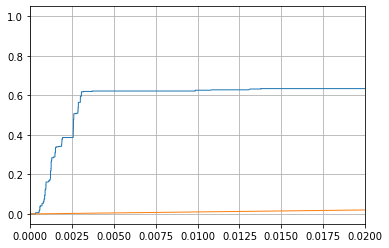

fpr: 0.0010025104884500682
tpr:  0.16155419222903886

79 355749 357 410
precision:  0.1811926605504587
recall:  0.16155419222903886
F-measure: 0.17081081081081081
MCC: 0.17001753995050856
Epoch 1/10
1583/1583 [==============================] - 29s 18ms/step - loss: 0.3825 - accuracy: 0.9387
Epoch 2/10
1583/1583 [==============================] - 26s 16ms/step - loss: 0.4294 - accuracy: 0.9319
Epoch 3/10
1583/1583 [==============================] - 26s 17ms/step - loss: 0.4700 - accuracy: 0.9160
Epoch 4/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.4630 - accuracy: 0.9206
Epoch 5/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.4687 - accuracy: 0.9322
Epoch 6/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.3245 - accuracy: 0.9539
Epoch 7/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.3425 - accuracy: 0.9446
Epoch 8/10
1583/1583 [==============================] - 27s 17ms/step - loss: 0.3159

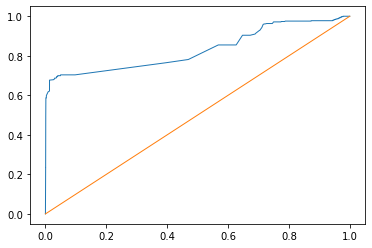

0.8315876415189766


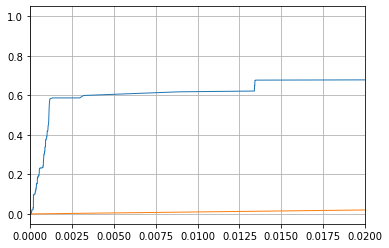

fpr: 0.0010025104884500682
tpr:  0.39263803680981596

192 355749 357 297
precision:  0.34972677595628415
recall:  0.39263803680981596
F-measure: 0.3699421965317919
MCC: 0.36964678078430746


In [4]:
#2층

l2param=0.001

for unit1 in [32, 64, 128, 256]:
  for unit2 in [32, 64, 128, 256]:
    model = Sequential()

    model.add(keras.Input(shape=(window_n, window_size, len(feature))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(units=unit1, return_sequences=True,
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)
                  ))
    model.add(LSTM(units=unit2,
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)
                  ))
    model.add(Dense(2, activation='sigmoid',
                    kernel_regularizer=tf.keras.regularizers.l2(l2param)))

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

    model.fit(training_set, epochs=10, verbose=1)

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt


    result = model.predict(test_set)[:, 1]

    #plt.figure()
    #plt.plot(result[:100])
    #plt.show()
    new_label = test_y[:,1]
    #new_label = 1-label
    #new_label = label.astype(np.int)

    #print(result[1500:1600])
    #print(new_label[1500:1600])
    print("="*20)
    print("unit1: ", unit1)
    print("unit2: ", unit2)
    fpr, tpr, thesholds = roc_curve(new_label, result)
    print(thesholds)
    plt.figure()
    plt.plot(fpr, tpr, lw=1)

    mean_fpr = np.linspace(0, 1, 100)
    plt.plot(mean_fpr, mean_fpr, lw=1)
    plt.show()
    print(auc(fpr, tpr))

    plt.figure()
    plt.plot(fpr, tpr, lw=1)

    mean_fpr = np.linspace(0, 1, 100)
    plt.xlim([0, 0.02])
    plt.grid("on")
    plt.plot(mean_fpr, mean_fpr, lw=1)
    plt.show()


    for i in range(len(fpr)):
      if fpr[i] > 0.001: #0.1%
        break;
    print("fpr:", fpr[i])
    print("tpr: ",tpr[i])
    print()
    predicted = result >= thesholds[i]
    TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
    TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
    FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
    FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

    print(TP,TN,FP,FN)

    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)

    print("precision: ", Precision)
    print("recall: ", Recall)
    print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
    print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))


Epoch 1/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.2388 - accuracy: 0.9480
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2529 - accuracy: 0.9409
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.3331 - accuracy: 0.9133
Epoch 4/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2590 - accuracy: 0.9430
Epoch 5/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2110 - accuracy: 0.9604
Epoch 6/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2306 - accuracy: 0.9578
Epoch 7/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.2849 - accuracy: 0.9304
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2695 - accuracy: 0.9406
Epoch 9/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2257 - accuracy: 0.9564
Epoch 10/10
1722/1722 [==============================] - 28s 16m

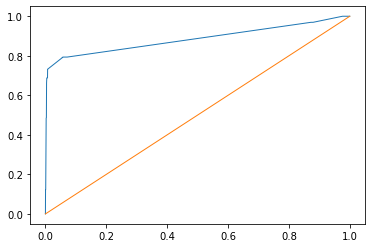

0.8848743181454038


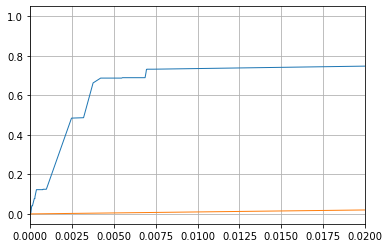

fpr: 0.0024675417466214836
tpr:  0.48466257668711654

237 390921 967 252
precision:  0.19684385382059802
recall:  0.48466257668711654
F-measure: 0.2799763733018311
MCC: 0.30758168199287134
Epoch 1/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.3033 - accuracy: 0.9245
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.3843 - accuracy: 0.8894
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2892 - accuracy: 0.9382
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.2400 - accuracy: 0.9552
Epoch 5/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2456 - accuracy: 0.9546
Epoch 6/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2039 - accuracy: 0.9624
Epoch 7/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2873 - accuracy: 0.9317
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.380

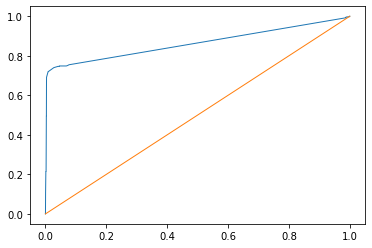

0.8632907887291698


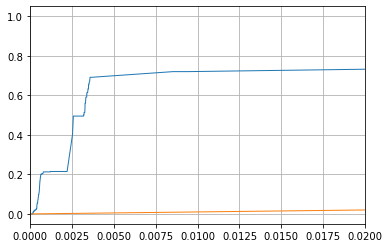

fpr: 0.0010002857959416976
tpr:  0.21267893660531698

104 391496 392 385
precision:  0.20967741935483872
recall:  0.21267893660531698
F-measure: 0.21116751269035533
MCC: 0.21018152018685943
Epoch 1/10
1722/1722 [==============================] - 35s 20ms/step - loss: 0.3737 - accuracy: 0.9242
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.4024 - accuracy: 0.9005
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2752 - accuracy: 0.9559
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.2590 - accuracy: 0.9559
Epoch 5/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4459 - accuracy: 0.8982
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4152 - accuracy: 0.89370s - loss:
Epoch 7/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.3942 - accuracy: 0.8896
Epoch 8/10
1722/1722 [==============================] - 27s 15ms/step - 

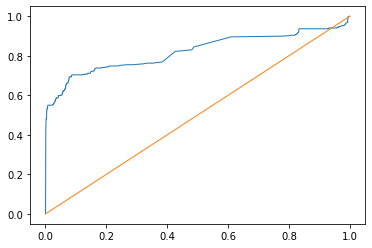

0.8209642573893445


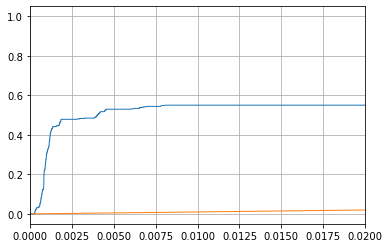

fpr: 0.0010028375454211407
tpr:  0.310838445807771

152 391495 393 337
precision:  0.27889908256880735
recall:  0.310838445807771
F-measure: 0.2940038684719536
MCC: 0.2935070508713523
Epoch 1/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4817 - accuracy: 0.9030
Epoch 2/10
1722/1722 [==============================] - 25s 15ms/step - loss: 0.4373 - accuracy: 0.9011
Epoch 3/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4273 - accuracy: 0.8892
Epoch 4/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.4454 - accuracy: 0.8931
Epoch 5/10
1722/1722 [==============================] - 25s 15ms/step - loss: 0.4692 - accuracy: 0.8897
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4326 - accuracy: 0.8889
Epoch 7/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4306 - accuracy: 0.8924
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4107 - a

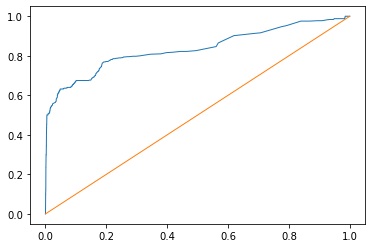

0.8358995505539457


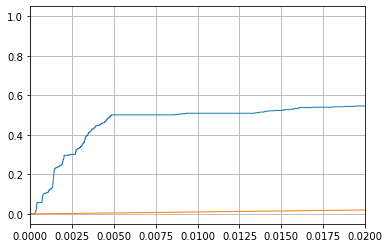

fpr: 0.0010002857959416976
tpr:  0.1083844580777096

53 391496 392 436
precision:  0.11910112359550562
recall:  0.1083844580777096
F-measure: 0.11349036402569593
MCC: 0.11256161581571952


In [2]:
#3층

l2param=0.001

for unit1 in [32, 64, 128, 256]:
  model = Sequential()

  model.add(keras.Input(shape=(window_n, window_size, len(feature))))
  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(units=unit1, return_sequences=True,
                kernel_regularizer=tf.keras.regularizers.l2(l2param)
                ))
  model.add(LSTM(units=unit1, return_sequences=True,
                kernel_regularizer=tf.keras.regularizers.l2(l2param)
                ))
  model.add(LSTM(units=unit1,
                kernel_regularizer=tf.keras.regularizers.l2(l2param)
                ))
  model.add(Dense(2, activation='sigmoid',
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)))

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

  model.fit(training_set, epochs=10, verbose=1)

  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt


  result = model.predict(test_set)[:, 1]

  #plt.figure()
  #plt.plot(result[:100])
  #plt.show()
  new_label = test_y[:,1]
  #new_label = 1-label
  #new_label = label.astype(np.int)

  #print(result[1500:1600])
  #print(new_label[1500:1600])
  print("="*20)
  print("unit1: ", unit1)
  #print("unit2: ", unit2)
  fpr, tpr, thesholds = roc_curve(new_label, result)
  print(thesholds)
  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()
  print(auc(fpr, tpr))

  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.xlim([0, 0.02])
  plt.grid("on")
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()


  for i in range(len(fpr)):
    if fpr[i] > 0.001: #0.1%
      break;
  print("fpr:", fpr[i])
  print("tpr: ",tpr[i])
  print()
  predicted = result >= thesholds[i]
  TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
  TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
  FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
  FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

  print(TP,TN,FP,FN)

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)

  print("precision: ", Precision)
  print("recall: ", Recall)
  print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
  print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))


Epoch 1/10
1722/1722 [==============================] - 32s 19ms/step - loss: 0.1629 - accuracy: 0.9577
Epoch 2/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.1546 - accuracy: 0.9627
Epoch 3/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.1701 - accuracy: 0.9571
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.2205 - accuracy: 0.9430
Epoch 5/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.2188 - accuracy: 0.9430
Epoch 6/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.2180 - accuracy: 0.9432
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2182 - accuracy: 0.9432
Epoch 8/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.2175 - accuracy: 0.9432
Epoch 9/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.2164 - accuracy: 0.9432
Epoch 10/10
1722/1722 [==============================] - 27s 15m

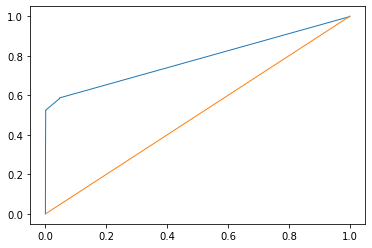

0.7813212298167574


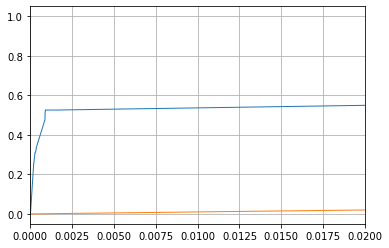

fpr: 0.0010436655370922303
tpr:  0.5255623721881391

257 391479 409 232
precision:  0.3858858858279451
recall:  0.5255623721881391
F-measure: 0.44502159615734876
MCC: 0.4495484370114454
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.2574 - accuracy: 0.9500
Epoch 2/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.3503 - accuracy: 0.9272
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2679 - accuracy: 0.9480
Epoch 4/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.2580 - accuracy: 0.9504
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2885 - accuracy: 0.9429
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.2614 - accuracy: 0.9554
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2571 - accuracy: 0.9593
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.2606 -

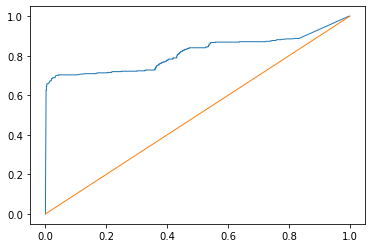

0.8149588689293723


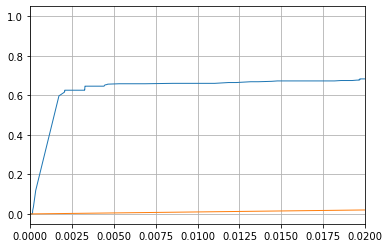

fpr: 0.0017173273996652105
tpr:  0.5971370143149284

292 391215 673 197
precision:  0.302590673543773
recall:  0.5971370143149284
F-measure: 0.4016505743131458
MCC: 0.4241094795648935
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.2895 - accuracy: 0.9481
Epoch 2/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.3109 - accuracy: 0.9535
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2973 - accuracy: 0.9546
Epoch 4/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.2790 - accuracy: 0.9584
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.3591 - accuracy: 0.9190
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.2917 - accuracy: 0.9594
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2962 - accuracy: 0.9618
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.3125 - a

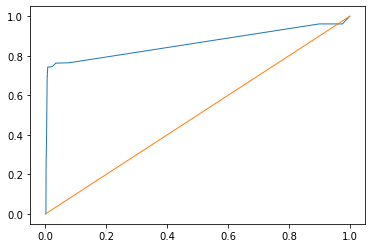

0.8623363561493343


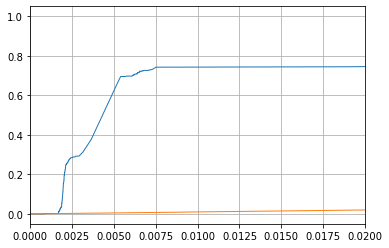

fpr: 0.0010002857959416976
tpr:  0.002044989775051125

1 391496 392 488
precision:  0.0025445292614390508
recall:  0.002044989775051125
F-measure: 0.0022675242893103196
MCC: 0.001165293935653455
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.3863 - accuracy: 0.9219
Epoch 2/10
1722/1722 [==============================] - 25s 15ms/step - loss: 0.3823 - accuracy: 0.9304
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4173 - accuracy: 0.8927
Epoch 4/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4362 - accuracy: 0.8936
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.3977 - accuracy: 0.9085
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.3682 - accuracy: 0.9258
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4044 - accuracy: 0.8926
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss:

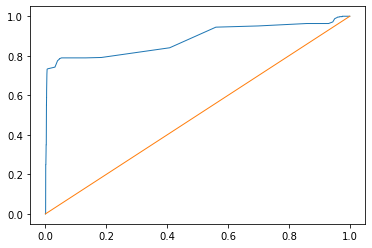

0.8825394699808644


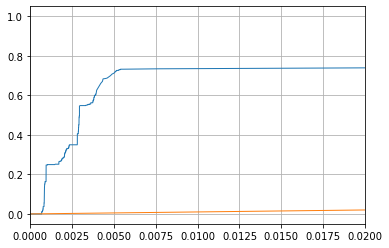

fpr: 0.001030906789695015
tpr:  0.2474437627811861

121 391484 404 368
precision:  0.23047619043229026
recall:  0.2474437627811861
F-measure: 0.23865872715981268
MCC: 0.23782541952713676
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.4640 - accuracy: 0.8943
Epoch 2/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4448 - accuracy: 0.8901
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4391 - accuracy: 0.8909
Epoch 4/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4668 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4661 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4693 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4533 - accuracy: 0.8893
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4678 

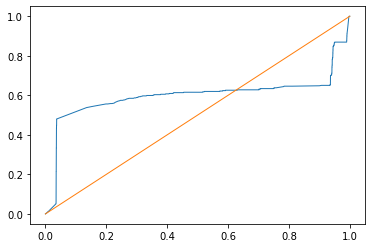

0.5975722650234276


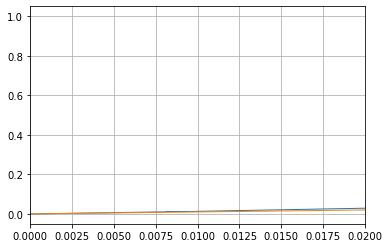

fpr: 0.007384762993508349
tpr:  0.010224948875255624

5 388994 2894 484
precision:  0.0017247326663772083
recall:  0.010224948875255624
F-measure: 0.0029515691606158954
MCC: 0.001170182820954429
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.5106 - accuracy: 0.8908
Epoch 2/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4720 - accuracy: 0.8891
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4742 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 27s 15ms/step - loss: 0.4758 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4831 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4815 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4830 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss:

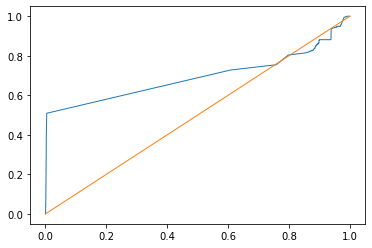

0.6938348041846938


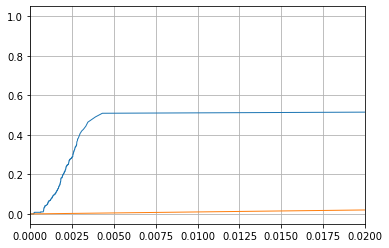

fpr: 0.001007941044380027
tpr:  0.04703476482617587

23 391493 395 466
precision:  0.055023923431812456
recall:  0.04703476482617587
F-measure: 0.05071659859191472
MCC: 0.04977815885991362
Epoch 1/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.5350 - accuracy: 0.8907
Epoch 2/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5116 - accuracy: 0.8891
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4978 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4931 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5099 - accuracy: 0.88911s
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4850 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5051 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5

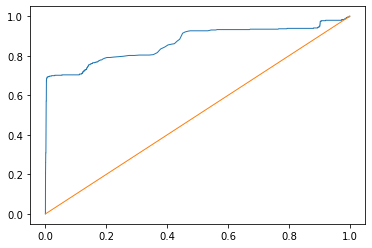

0.8667865915865783


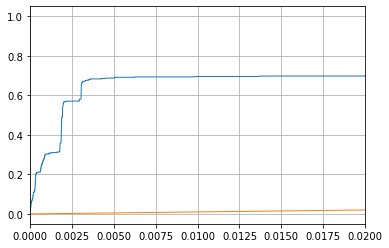

fpr: 0.0010538725350100028
tpr:  0.30265848670756645

148 391475 413 341
precision:  0.2638146167087675
recall:  0.30265848670756645
F-measure: 0.2819047121130247
MCC: 0.28161192015764147
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.5861 - accuracy: 0.8897
Epoch 2/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5458 - accuracy: 0.8891
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5212 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5218 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5134 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5105 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5601 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5258

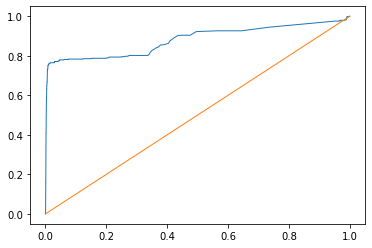

0.8801202601436058


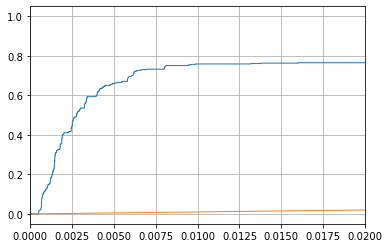

fpr: 0.0010028375454211407
tpr:  0.12883435582822086

63 391495 393 426
precision:  0.13815789470654433
recall:  0.12883435582822086
F-measure: 0.13333328338021525
MCC: 0.13237074062326395
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6125 - accuracy: 0.8891
Epoch 2/10
1722/1722 [==============================] - 27s 15ms/step - loss: 0.5169 - accuracy: 0.8891
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5569 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5767 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5652 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.5511 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.5523 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.567

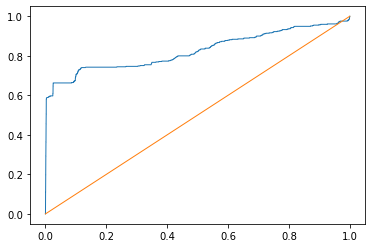

0.8254536118244877


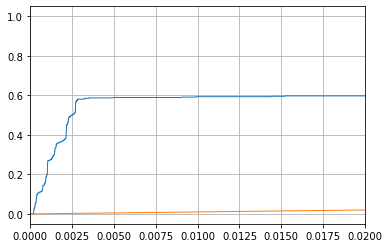

fpr: 0.0010002857959416976
tpr:  0.19631901840490798

96 391496 392 393
precision:  0.19672131143509808
recall:  0.19631901840490798
F-measure: 0.19651990903829236
MCC: 0.1955186023878401
Epoch 1/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.1535 - accuracy: 0.9607
Epoch 2/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.1462 - accuracy: 0.9652
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.1510 - accuracy: 0.9652
Epoch 4/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.1953 - accuracy: 0.9501
Epoch 5/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.1416 - accuracy: 0.9659
Epoch 6/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.1435 - accuracy: 0.9670
Epoch 7/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.1407 - accuracy: 0.9680
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.1367

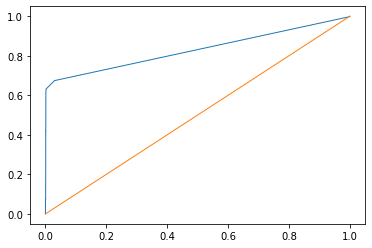

0.8301155798489065


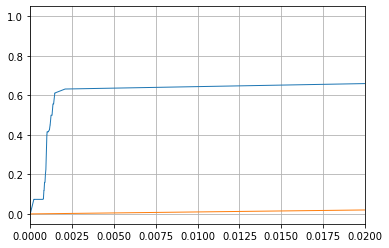

fpr: 0.0010002857959416976
tpr:  0.3987730061349693

195 391496 392 294
precision:  0.3321976149348897
recall:  0.3987730061349693
F-measure: 0.36245348197959526
MCC: 0.3630987912121614
Epoch 1/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.2688 - accuracy: 0.9516
Epoch 2/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.3443 - accuracy: 0.9361
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2899 - accuracy: 0.9518
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.3787 - accuracy: 0.9169
Epoch 5/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.3394 - accuracy: 0.9471
Epoch 6/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.2877 - accuracy: 0.9588
Epoch 7/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.2799 - accuracy: 0.9576
Epoch 8/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.2934 -

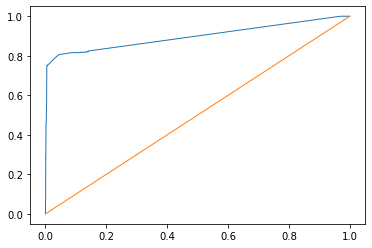

0.8977242710178784


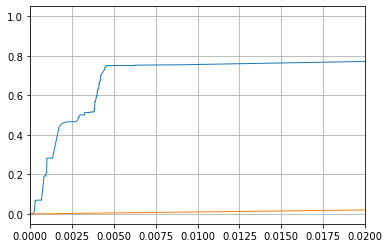

fpr: 0.0010002857959416976
tpr:  0.26789366053169733

131 391496 392 358
precision:  0.2504780114243828
recall:  0.26789366053169733
F-measure: 0.2588932306632758
MCC: 0.25808358746705423
Epoch 1/10
1722/1722 [==============================] - 32s 19ms/step - loss: 0.3549 - accuracy: 0.9352
Epoch 2/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.4262 - accuracy: 0.9261
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.3648 - accuracy: 0.9507
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.4118 - accuracy: 0.9166
Epoch 5/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.4733 - accuracy: 0.8967
Epoch 6/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.4048 - accuracy: 0.9257
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.3858 - accuracy: 0.9195
Epoch 8/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.4341

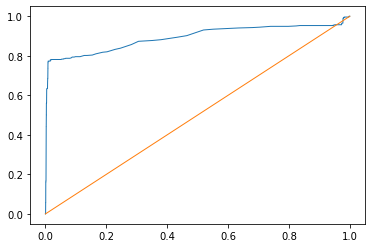

0.8922525112972054


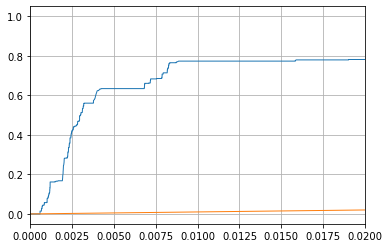

fpr: 0.0010104927938594701
tpr:  0.05930470347648262

29 391492 396 460
precision:  0.0682352941015917
recall:  0.05930470347648262
F-measure: 0.0634572806540043
MCC: 0.062524557312615
Epoch 1/10
1722/1722 [==============================] - 32s 19ms/step - loss: 0.4627 - accuracy: 0.9086
Epoch 2/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.5231 - accuracy: 0.8973
Epoch 3/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.4802 - accuracy: 0.9092
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.4827 - accuracy: 0.8983
Epoch 5/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.5037 - accuracy: 0.8977
Epoch 6/10
1722/1722 [==============================] - 26s 15ms/step - loss: 0.4948 - accuracy: 0.8933
Epoch 7/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.4715 - accuracy: 0.8988
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.4548 - 

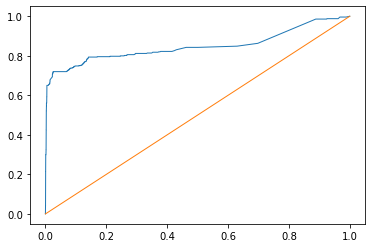

0.8478038167200561


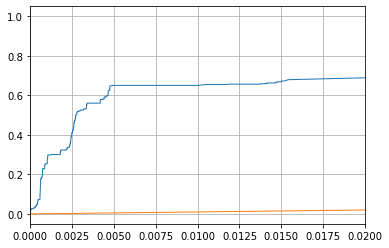

fpr: 0.0010181480422977993
tpr:  0.25357873210633947

124 391489 399 365
precision:  0.2370936902032326
recall:  0.25357873210633947
F-measure: 0.24505923856978162
MCC: 0.24422390809002378
Epoch 1/10
1722/1722 [==============================] - 32s 19ms/step - loss: 0.5639 - accuracy: 0.8979
Epoch 2/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.5753 - accuracy: 0.8908
Epoch 3/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.5253 - accuracy: 0.8913
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.5637 - accuracy: 0.8905
Epoch 5/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.5853 - accuracy: 0.8909
Epoch 6/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.5811 - accuracy: 0.8893
Epoch 7/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.5730 - accuracy: 0.8907
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.531

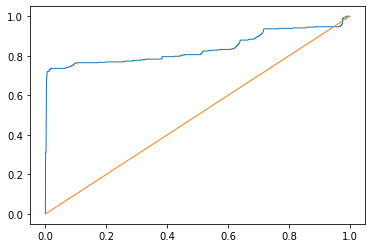

0.837482347529368


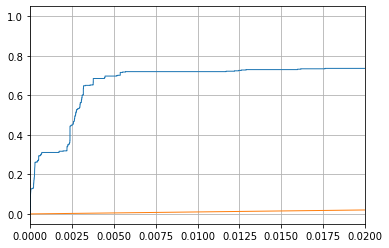

fpr: 0.0014621524517208998
tpr:  0.310838445807771

152 391315 573 337
precision:  0.20965517238487516
recall:  0.310838445807771
F-measure: 0.2504118134834222
MCC: 0.2541577969009475
Epoch 1/10
1722/1722 [==============================] - 33s 19ms/step - loss: 0.6526 - accuracy: 0.8961
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6037 - accuracy: 0.8893
Epoch 3/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.6027 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6008 - accuracy: 0.8893
Epoch 5/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.5722 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6125 - accuracy: 0.8892
Epoch 7/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.6220 - accuracy: 0.8893
Epoch 8/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.5720 - a

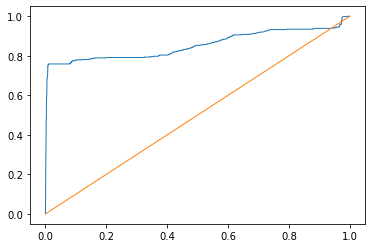

0.8539934138354459


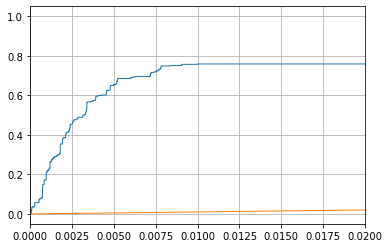

fpr: 0.0010028375454211407
tpr:  0.21267893660531698

104 391495 393 385
precision:  0.20925553315709144
recall:  0.21267893660531698
F-measure: 0.21095329683789227
MCC: 0.2099678002408042
Epoch 1/10
1722/1722 [==============================] - 34s 19ms/step - loss: 0.6801 - accuracy: 0.8949
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6125 - accuracy: 0.8892
Epoch 3/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.6182 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.6529 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6315 - accuracy: 0.8892
Epoch 6/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.6409 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.6260 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.607

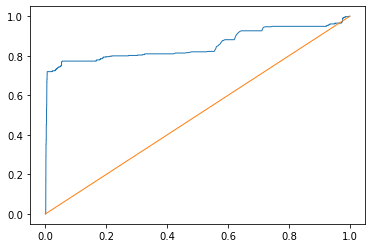

0.854458239268229


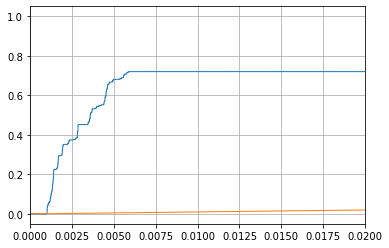

fpr: 0.001007941044380027
tpr:  0.0

0 391493 395 489
precision:  0.0
recall:  0.0
F-measure: 0.0
MCC: -0.0011212441780478794
Epoch 1/10
1722/1722 [==============================] - 33s 19ms/step - loss: 0.7541 - accuracy: 0.8900
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6717 - accuracy: 0.8891
Epoch 3/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6368 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6959 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6470 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.7025 - accuracy: 0.8892
Epoch 7/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7030 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6792 - accuracy: 0.8891
Epoch 9/10
1722/1722 [====================

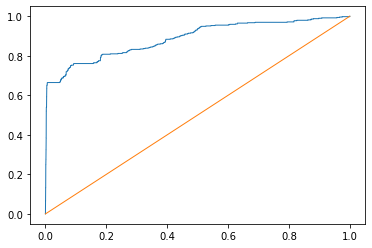

0.8880796233713786


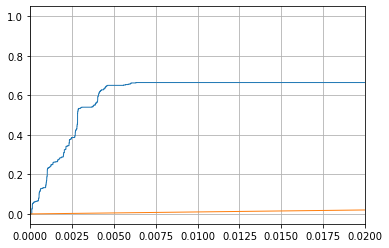

fpr: 0.0010053892949005837
tpr:  0.18813905930470348

92 391494 394 397
precision:  0.18930041148368304
recall:  0.18813905930470348
F-measure: 0.18871789869907962
MCC: 0.18770973600877996
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.8256 - accuracy: 0.8887
Epoch 2/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7222 - accuracy: 0.8891
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.7180 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7345 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.7123 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7428 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.7138 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.740

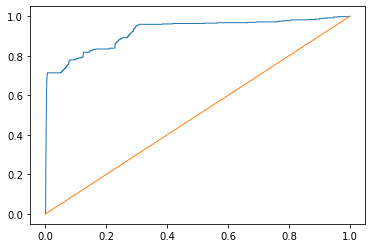

0.9224402999162482


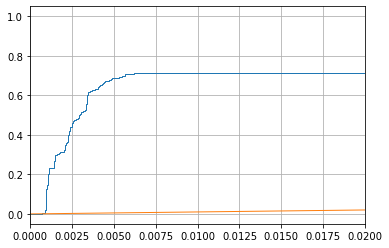

fpr: 0.0010053892949005837
tpr:  0.12883435582822086

63 391494 394 426
precision:  0.13785557983854363
recall:  0.12883435582822086
F-measure: 0.13319233904949376
MCC: 0.13222336488416514
Epoch 1/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.1465 - accuracy: 0.9630
Epoch 2/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.1473 - accuracy: 0.9625
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.1378 - accuracy: 0.9678
Epoch 4/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.1727 - accuracy: 0.9581
Epoch 5/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.1779 - accuracy: 0.9638
Epoch 6/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.1833 - accuracy: 0.9555
Epoch 7/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.1787 - accuracy: 0.9555
Epoch 8/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.160

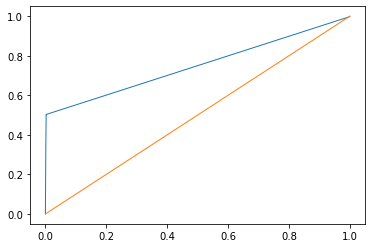

0.7494263364508719


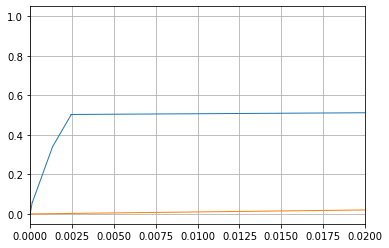

fpr: 0.001342220226187074
tpr:  0.34151329243353784

167 391362 526 322
precision:  0.24098124094646736
recall:  0.34151329243353784
F-measure: 0.2825718634789838
MCC: 0.2858238139480766
Epoch 1/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.3538 - accuracy: 0.9394
Epoch 2/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.3448 - accuracy: 0.9545
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.3108 - accuracy: 0.9603
Epoch 4/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.3059 - accuracy: 0.9625
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4689 - accuracy: 0.9260
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.3479 - accuracy: 0.9486
Epoch 7/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2875 - accuracy: 0.9629
Epoch 8/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.4093 

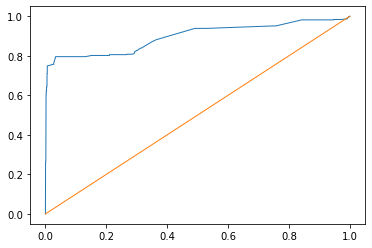

0.8963595364294643


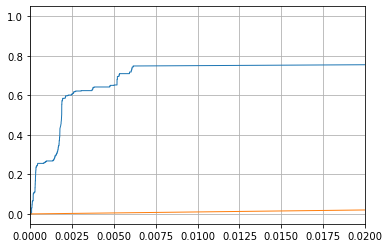

fpr: 0.001178908259502715
tpr:  0.26789366053169733

131 391426 462 358
precision:  0.22091062390878405
recall:  0.26789366053169733
F-measure: 0.24214412788873538
MCC: 0.2422322339498548
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.4149 - accuracy: 0.9341
Epoch 2/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.4780 - accuracy: 0.9332
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.4708 - accuracy: 0.9392
Epoch 4/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.5184 - accuracy: 0.9296
Epoch 5/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.5022 - accuracy: 0.9254
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.5729 - accuracy: 0.9048
Epoch 7/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.4784 - accuracy: 0.9339
Epoch 8/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.4088

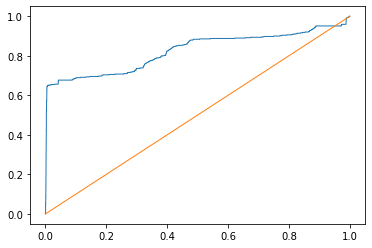

0.8245129294693522


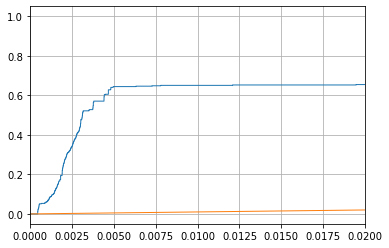

fpr: 0.0010155962928183563
tpr:  0.06134969325153374

30 391490 398 459
precision:  0.07009345792754826
recall:  0.06134969325153374
F-measure: 0.0654307026678097
MCC: 0.0644855246557322
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6004 - accuracy: 0.9238
Epoch 2/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6255 - accuracy: 0.9062
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.6240 - accuracy: 0.9075
Epoch 4/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.5444 - accuracy: 0.9224
Epoch 5/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.6290 - accuracy: 0.8995
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6274 - accuracy: 0.8997
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.6193 - accuracy: 0.8991
Epoch 8/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.6056 

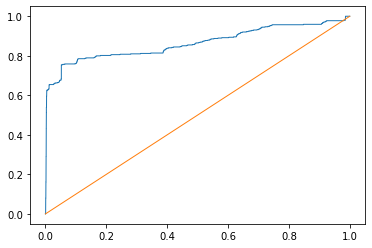

0.8636277422905438


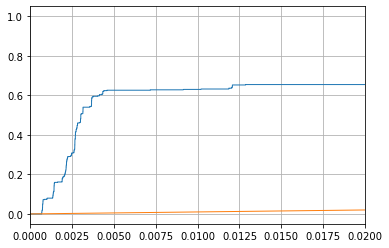

fpr: 0.0010155962928183563
tpr:  0.07566462167689161

37 391490 398 452
precision:  0.08505747124481437
recall:  0.07566462167689161
F-measure: 0.0800865302487145
MCC: 0.07914155372335843
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7438 - accuracy: 0.9045
Epoch 2/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7812 - accuracy: 0.8935
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.7248 - accuracy: 0.8913
Epoch 4/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7622 - accuracy: 0.8920
Epoch 5/10
1722/1722 [==============================] - 28s 17ms/step - loss: 0.7246 - accuracy: 0.8948
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7009 - accuracy: 0.8977
Epoch 7/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.7359 - accuracy: 0.8922
Epoch 8/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7210

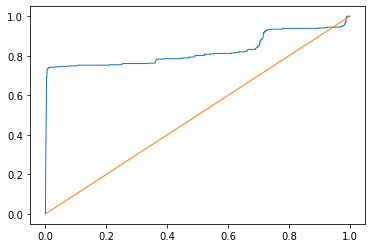

0.8247476825940085


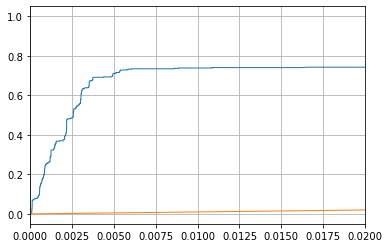

fpr: 0.0010487690360511167
tpr:  0.2556237218813906

125 391477 411 364
precision:  0.2332089551803715
recall:  0.2556237218813906
F-measure: 0.243902389105733
MCC: 0.24317220331282996
Epoch 1/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7836 - accuracy: 0.9063
Epoch 2/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.8275 - accuracy: 0.8939
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.8137 - accuracy: 0.8900
Epoch 4/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7865 - accuracy: 0.8899
Epoch 5/10
1722/1722 [==============================] - 28s 17ms/step - loss: 0.7998 - accuracy: 0.8903
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7906 - accuracy: 0.8897
Epoch 7/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.8052 - accuracy: 0.8904
Epoch 8/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.7823 - 

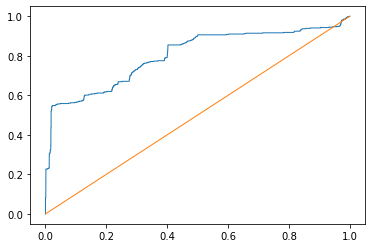

0.8020793830790267


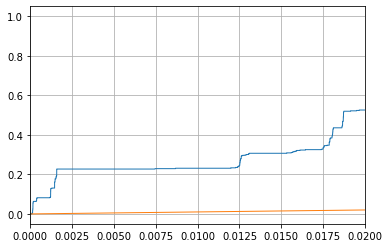

fpr: 0.0011712530110643857
tpr:  0.081799591002045

40 391429 459 449
precision:  0.08016032062521837
recall:  0.081799591002045
F-measure: 0.08097160991598588
MCC: 0.07981746852554204
Epoch 1/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.9066 - accuracy: 0.8952
Epoch 2/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.9280 - accuracy: 0.8900
Epoch 3/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.8378 - accuracy: 0.8897
Epoch 4/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.8612 - accuracy: 0.8897
Epoch 5/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.8338 - accuracy: 0.8896
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.8707 - accuracy: 0.8895
Epoch 7/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.8417 - accuracy: 0.8897
Epoch 8/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.8763 - 

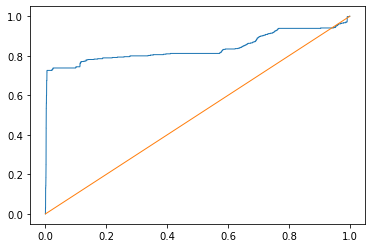

0.838556537521634


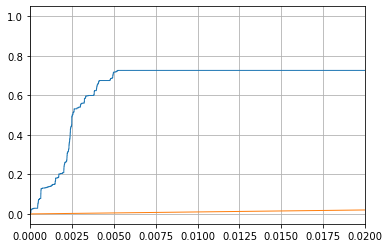

fpr: 0.0010487690360511167
tpr:  0.13496932515337423

66 391477 411 423
precision:  0.13836477984520654
recall:  0.13496932515337423
F-measure: 0.13664591272650772
MCC: 0.13559265208510854
Epoch 1/10
1722/1722 [==============================] - 32s 18ms/step - loss: 1.0134 - accuracy: 0.8913
Epoch 2/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.9431 - accuracy: 0.8898
Epoch 3/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.9179 - accuracy: 0.8893
Epoch 4/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.9419 - accuracy: 0.8895
Epoch 5/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.9481 - accuracy: 0.8892
Epoch 6/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.9584 - accuracy: 0.8892
Epoch 7/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.9531 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.948

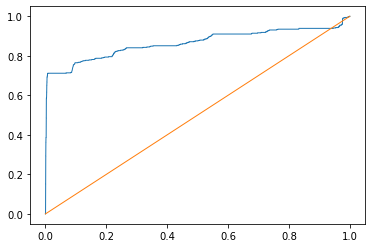

0.8642743029037887


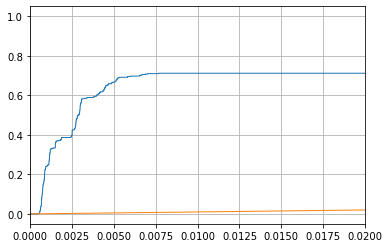

fpr: 0.0010155962928183563
tpr:  0.24130879345603273

118 391490 398 371
precision:  0.22868217049831743
recall:  0.24130879345603273
F-measure: 0.23482582065949928
MCC: 0.2339301512473645
Epoch 1/10
1722/1722 [==============================] - 32s 18ms/step - loss: 1.1310 - accuracy: 0.8893
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.9930 - accuracy: 0.8892
Epoch 3/10
1722/1722 [==============================] - 27s 16ms/step - loss: 1.0077 - accuracy: 0.8891
Epoch 4/10
1722/1722 [==============================] - 27s 16ms/step - loss: 1.0121 - accuracy: 0.8891
Epoch 5/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.9920 - accuracy: 0.8891
Epoch 6/10
1722/1722 [==============================] - 28s 16ms/step - loss: 1.0229 - accuracy: 0.8891
Epoch 7/10
1722/1722 [==============================] - 27s 16ms/step - loss: 1.0129 - accuracy: 0.8891
Epoch 8/10
1722/1722 [==============================] - 27s 16ms/step - loss: 1.066

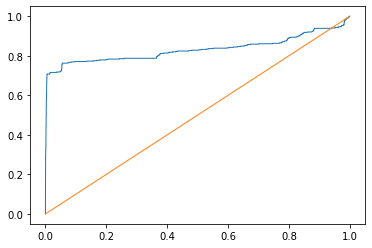

0.8319391205592148


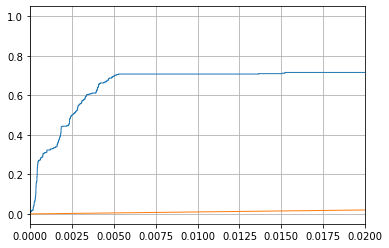

fpr: 0.0010002857959416976
tpr:  0.3169734151329243

155 391496 392 334
precision:  0.28336380250761173
recall:  0.3169734151329243
F-measure: 0.29922774935563806
MCC: 0.2987742766407739


In [5]:
#1층
#l2param grid search
for unit in [64, 128, 256]:
  for l2param in [0.0, 0.001, 0.002, 0.005, 0.01, 0.015, 0.02, 0.03, 0.05]:

    model = Sequential()

    model.add(keras.Input(shape=(window_n, window_size, len(feature))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(units=unit,
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)
                  ))
    model.add(Dense(2, activation='sigmoid',
                    kernel_regularizer=tf.keras.regularizers.l2(l2param)))

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

    model.fit(training_set, epochs=10, verbose=1)

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt


    result = model.predict(test_set)[:, 1]

    #plt.figure()
    #plt.plot(result[:100])
    #plt.show()
    new_label = test_y[:,1]
    #new_label = 1-label
    #new_label = label.astype(np.int)

    #print(result[1500:1600])
    #print(new_label[1500:1600])
    print("="*20)
    print("l2param: ", l2param)
    print("unit: ", unit)
    fpr, tpr, thesholds = roc_curve(new_label, result)
    print(thesholds)
    plt.figure()
    plt.plot(fpr, tpr, lw=1)

    mean_fpr = np.linspace(0, 1, 100)
    plt.plot(mean_fpr, mean_fpr, lw=1)
    plt.show()
    print(auc(fpr, tpr))

    plt.figure()
    plt.plot(fpr, tpr, lw=1)

    mean_fpr = np.linspace(0, 1, 100)
    plt.xlim([0, 0.02])
    plt.grid("on")
    plt.plot(mean_fpr, mean_fpr, lw=1)
    plt.show()


    for i in range(len(fpr)):
      if fpr[i] > 0.001: #0.1%
        break;
    print("fpr:", fpr[i])
    print("tpr: ",tpr[i])
    print()
    predicted = result >= thesholds[i]
    TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
    TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
    FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
    FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

    print(TP,TN,FP,FN)

    Precision = TP/(TP+FP+1e-7)
    Recall = TP/(TP+FN)

    print("precision: ", Precision)
    print("recall: ", Recall)
    print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
    print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))+1e-7)


Epoch 1/10
1722/1722 [==============================] - 34s 20ms/step - loss: 0.2978 - accuracy: 0.9337
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.3292 - accuracy: 0.9246
Epoch 3/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.2631 - accuracy: 0.9500
Epoch 4/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2377 - accuracy: 0.9532
Epoch 5/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.2014 - accuracy: 0.9610
Epoch 6/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2379 - accuracy: 0.9525
Epoch 7/10
1722/1722 [==============================] - 30s 17ms/step - loss: 0.2178 - accuracy: 0.9585
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.2095 - accuracy: 0.9623
Epoch 9/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.2590 - accuracy: 0.9468
Epoch 10/10
1722/1722 [==============================] - 28s 16m

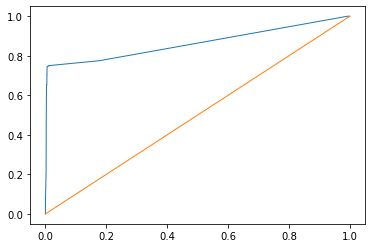

0.864199117614423


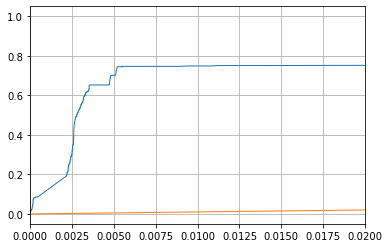

fpr: 0.0020260890866778264
tpr:  0.18404907975460122

90 391094 794 399
precision:  0.10180995475113122
recall:  0.18404907975460122
F-measure: 0.13109978150036417
MCC: 0.13544828941502865


In [6]:
#2층

l2param=0.001

for unit1 in [64]:
  for unit2 in [32]:
    model = Sequential()

    model.add(keras.Input(shape=(window_n, window_size, len(feature))))
    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(units=unit1, return_sequences=True,
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)
                  ))
    model.add(LSTM(units=unit2,
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)
                  ))
    model.add(Dense(2, activation='sigmoid',
                    kernel_regularizer=tf.keras.regularizers.l2(l2param)))

    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.005), metrics=['accuracy'])

    model.fit(training_set, epochs=10, verbose=1)

    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt


    result = model.predict(test_set)[:, 1]

    #plt.figure()
    #plt.plot(result[:100])
    #plt.show()
    new_label = test_y[:,1]
    #new_label = 1-label
    #new_label = label.astype(np.int)

    #print(result[1500:1600])
    #print(new_label[1500:1600])
    print("="*20)
    print("unit1: ", unit1)
    print("unit2: ", unit2)
    fpr, tpr, thesholds = roc_curve(new_label, result)
    print(thesholds)
    plt.figure()
    plt.plot(fpr, tpr, lw=1)

    mean_fpr = np.linspace(0, 1, 100)
    plt.plot(mean_fpr, mean_fpr, lw=1)
    plt.show()
    print(auc(fpr, tpr))

    plt.figure()
    plt.plot(fpr, tpr, lw=1)

    mean_fpr = np.linspace(0, 1, 100)
    plt.xlim([0, 0.02])
    plt.grid("on")
    plt.plot(mean_fpr, mean_fpr, lw=1)
    plt.show()


    for i in range(len(fpr)):
      if fpr[i] > 0.001: #0.1%
        break;
    print("fpr:", fpr[i])
    print("tpr: ",tpr[i])
    print()
    predicted = result >= thesholds[i]
    TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
    TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
    FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
    FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

    print(TP,TN,FP,FN)

    Precision = TP/(TP+FP)
    Recall = TP/(TP+FN)

    print("precision: ", Precision)
    print("recall: ", Recall)
    print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
    print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))


Epoch 1/10
1722/1722 [==============================] - 32s 19ms/step - loss: 0.1978 - accuracy: 0.9622
Epoch 2/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.1844 - accuracy: 0.9604
Epoch 3/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.1848 - accuracy: 0.9582
Epoch 4/10
1722/1722 [==============================] - 29s 17ms/step - loss: 0.1838 - accuracy: 0.9629
Epoch 5/10
1722/1722 [==============================] - 32s 18ms/step - loss: 0.1654 - accuracy: 0.9651
Epoch 6/10
1722/1722 [==============================] - 27s 16ms/step - loss: 0.1627 - accuracy: 0.9648
Epoch 7/10
1722/1722 [==============================] - 31s 18ms/step - loss: 0.1673 - accuracy: 0.9667
Epoch 8/10
1722/1722 [==============================] - 28s 16ms/step - loss: 0.1658 - accuracy: 0.9692
Epoch 9/10
1722/1722 [==============================] - 30s 18ms/step - loss: 0.1642 - accuracy: 0.9701
Epoch 10/10
1722/1722 [==============================] - 27s 16m

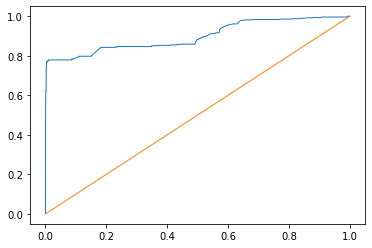

0.8998292843070141


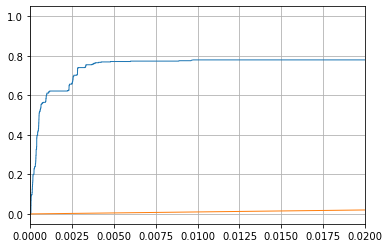

fpr: 0.0010002857959416976
tpr:  0.6073619631901841

297 391496 392 192
precision:  0.4310595065312046
recall:  0.6073619631901841
F-measure: 0.5042444821731749
MCC: 0.5109606006254308


In [7]:
#1층

l2param=0.001

for unit in [128]:
  
  model = Sequential()

  model.add(keras.Input(shape=(window_n, window_size, len(feature))))
  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(units=unit,
                kernel_regularizer=tf.keras.regularizers.l2(l2param)
                ))
  model.add(Dense(2, activation='sigmoid',
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)))

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

  model.fit(training_set, epochs=10, verbose=1)

  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt


  result = model.predict(test_set)[:, 1]

  #plt.figure()
  #plt.plot(result[:100])
  #plt.show()
  new_label = test_y[:,1]
  #new_label = 1-label
  #new_label = label.astype(np.int)

  #print(result[1500:1600])
  #print(new_label[1500:1600])
  print("="*20)
  print("unit: ", unit)
  fpr, tpr, thesholds = roc_curve(new_label, result)
  print(thesholds)
  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()
  print(auc(fpr, tpr))

  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.xlim([0, 0.02])
  plt.grid("on")
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()


  for i in range(len(fpr)):
    if fpr[i] > 0.001: #0.1%
      break;
  print("fpr:", fpr[i])
  print("tpr: ",tpr[i])
  print()
  predicted = result >= thesholds[i]
  TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
  TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
  FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
  FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

  print(TP,TN,FP,FN)

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)

  print("precision: ", Precision)
  print("recall: ", Recall)
  print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
  print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))


training time (sec):  373.61484384536743
training time per sample (sec):  5.5938991168603456e-05
reference time (sec): 114.18776845932007
reference time per sample (sec):  5.006303201366142e-05
unit:  128
[1.9911585  0.9911584  0.99022335 ... 0.00925036 0.00925035 0.0084289 ]


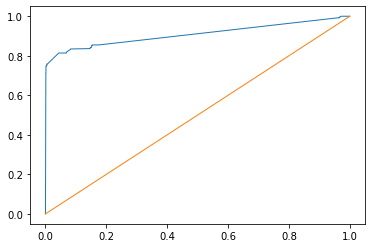

0.9080201547684393


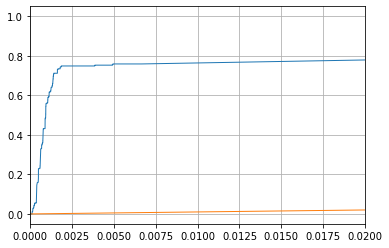

1%
fpr: 0.006647982736293907
tpr:  0.7586912065439673

371 2265231 15160 118
precision:  0.023887708454059624
recall:  0.7586912065439673
F-measure: 0.046317103620474406


TypeError: loop of ufunc does not support argument 0 of type int which has no callable sqrt method

In [2]:
#1층
import time

l2param=0.001

for unit in [128]:
  
  model = Sequential()

  model.add(keras.Input(shape=(window_n, window_size, len(feature))))
  model.add(TimeDistributed(Flatten()))

  model.add(LSTM(units=unit,
                kernel_regularizer=tf.keras.regularizers.l2(l2param)
                ))
  model.add(Dense(2, activation='sigmoid',
                  kernel_regularizer=tf.keras.regularizers.l2(l2param)))

  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0008), metrics=['accuracy'])
  start = time.time()
  model.fit(training_set, epochs=10, verbose=0)
  end = time.time()
  
  print("training time (sec): ", end - start)
  print("training time per sample (sec): ", (end-start)/(training_x.shape[0]*10))
  
  from sklearn.metrics import roc_curve, auc
  import matplotlib.pyplot as plt

  start = time.time()
  result = model.predict(test_set)[:, 1]
  end = time.time()
  
  print("reference time (sec):", end-start)
  print("reference time per sample (sec): ", (end-start)/test_x.shape[0])
  #plt.figure()
  #plt.plot(result[:100])
  #plt.show()
  new_label = test_y[:,1]
  #new_label = 1-label
  #new_label = label.astype(np.int)

  #print(result[1500:1600])
  #print(new_label[1500:1600])
  print("="*20)
  print("unit: ", unit)
  fpr, tpr, thesholds = roc_curve(new_label, result)
  print(thesholds)
  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()
  print(auc(fpr, tpr))

  plt.figure()
  plt.plot(fpr, tpr, lw=1)

  mean_fpr = np.linspace(0, 1, 100)
  plt.xlim([0, 0.02])
  plt.grid("on")
  plt.plot(mean_fpr, mean_fpr, lw=1)
  plt.show()
  print("1%")
  for i in range(len(fpr)):
    if fpr[i] > 0.01: #1%
      if (i > 0): i -= 1
      break;
  print("fpr:", fpr[i])
  print("tpr: ",tpr[i])
  print()
  predicted = result >= thesholds[i]
  TP = np.int64(sum(np.logical_and(new_label==1,  predicted==1)))
  TN = np.int64(sum(np.logical_and(new_label==0,  predicted==0)))
  FP = np.int64(sum(np.logical_and(new_label==0,  predicted==1)))
  FN = np.int64(sum(np.logical_and(new_label==1,  predicted==0)))

  print(TP,TN,FP,FN)

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)

  print("precision: ", Precision)
  print("recall: ", Recall)
  print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
  print("MCC:", (TP*TN-FP*FN)/np.sqrt(np.sqrt(TP+FN)*np.sqrt(TP+FP)*np.sqrt(TN+FP)*np.sqrt(TN+FN)))
  
  print("0.5%")
  for i in range(len(fpr)):
    if fpr[i] > 0.005: #0.5%
      if (i > 0): i -= 1
      break;
  print("fpr:", fpr[i])
  print("tpr: ",tpr[i])
  print()
  predicted = result >= thesholds[i]
  TP = np.int64(sum(np.logical_and(new_label==1,  predicted==1)))
  TN = np.int64(sum(np.logical_and(new_label==0,  predicted==0)))
  FP = np.int64(sum(np.logical_and(new_label==0,  predicted==1)))
  FN = np.int64(sum(np.logical_and(new_label==1,  predicted==0)))

  print(TP,TN,FP,FN)

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)

  print("precision: ", Precision)
  print("recall: ", Recall)
  print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
  print("MCC:", (TP*TN-FP*FN)/np.sqrt(np.sqrt(TP+FN)*np.sqrt(TP+FP)*np.sqrt(TN+FP)*np.sqrt(TN+FN)))

  print("0.1%")
  for i in range(len(fpr)):
    if fpr[i] > 0.001: #0.1%
      if (i > 0): i -= 1
      break;
  print("fpr:", fpr[i])
  print("tpr: ",tpr[i])
  print()
  predicted = result >= thesholds[i]
  TP = np.int64(sum(np.logical_and(new_label==1,  predicted==1)))
  TN = np.int64(sum(np.logical_and(new_label==0,  predicted==0)))
  FP = np.int64(sum(np.logical_and(new_label==0,  predicted==1)))
  FN = np.int64(sum(np.logical_and(new_label==1,  predicted==0)))

  print(TP,TN,FP,FN)

  Precision = TP/(TP+FP)
  Recall = TP/(TP+FN)

  print("precision: ", Precision)
  print("recall: ", Recall)
  print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
  print("MCC:", (TP*TN-FP*FN)/np.sqrt(np.sqrt(TP+FN)*np.sqrt(TP+FP)*np.sqrt(TN+FP)*np.sqrt(TN+FN)))


In [4]:
print("training time per sample (sec): ", 385.6669476032257/(training_x.shape[0]*10))


training time per sample (sec):  5.7743476554502524e-05


In [3]:
import pickle
data_dictionary = {}
data_dictionary['result'] = result
data_dictionary['new_label'] = new_label

with open("LSTM_DICT.pck", "wb") as file:
  pickle.dump(data_dictionary, file)

크기 392322
비정상 489
[1.9335938  0.93359375 0.9335937  ... 0.01257747 0.01257746 0.01255004]


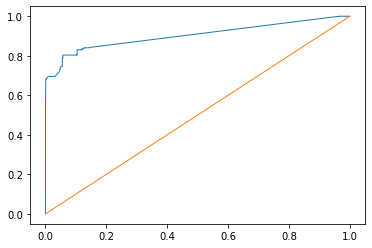

0.9026213574554164


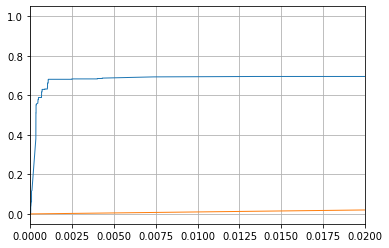

1%
fpr: 0.007403664316175514
tpr:  0.6932515337423313

339 388932 2901 150
precision:  0.10462962962962963
recall:  0.6932515337423313
F-measure: 0.18181818181818182
MCC: 0.26738660874794673
0.5%
fpr: 0.004320718265179298
tpr:  0.6871165644171779

336 390140 1693 153
precision:  0.16559881715130606
recall:  0.6871165644171779
F-measure: 0.266878474980143
MCC: 0.3358608633165872
0.1%
fpr: 0.0009953219866626853
tpr:  0.6319018404907976

309 391443 390 180
precision:  0.44206008583690987
recall:  0.6319018404907976
F-measure: 0.5202020202020202
MCC: 0.5278338837812235


In [2]:
#load_data
import pickle

with open("LSTM_DICT.pck", "rb") as file:
  data_dictionary = pickle.load(file)
result = data_dictionary['result']
new_label = data_dictionary['new_label']

import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale
from sklearn import mixture
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt



print('크기', len(new_label))
print('비정상', sum(new_label))
fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)
mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()

print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100


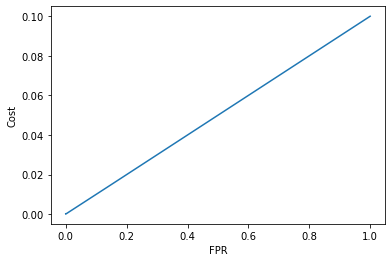

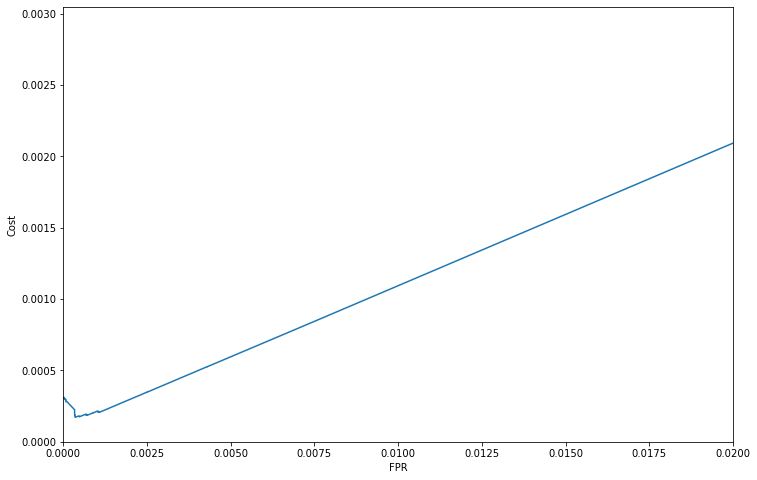

0.0003496387491609946
0.00017357863170682492


In [6]:

#총 데이터 중 정상 데이터 비율
normal_n = 2855614
#총 데이터중 비정상 데이터 비율
abnormal_n = 978

p_plus = abnormal_n/(normal_n+abnormal_n)
p_minus = normal_n/(normal_n+abnormal_n)

w_FNR = 0.9
w_FPR = 0.1

cost = []
for i in range(len(fpr)):
  if i % 100 == 0:
    print(i)
  predicted = result >= thesholds[i]
  TP = np.sum(np.logical_and(new_label==1,  predicted==1))
  TN = np.sum(np.logical_and(new_label==0,  predicted==0))
  FP = np.sum(np.logical_and(new_label==0,  predicted==1))
  FN = np.sum(np.logical_and(new_label==1,  predicted==0))
  FNR = FN/(FN+TP) #비정상 데이터중 미알람 비율
  FPR = FP/(FP+TN) #정상 데이터중 비정상 알람 비율
  
  cost.append(w_FNR*FNR*p_plus + w_FPR*FPR*p_minus)


plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.show()

plt.figure(figsize=[12, 8])
plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.xlim([0, 0.02])
plt.ylim([0, cost[400]])
plt.show()

print(fpr[np.argmin(cost)])
print(np.amin(cost))

[1.980121   0.980121   0.9795249  ... 0.03760123 0.03760123 0.03760121]


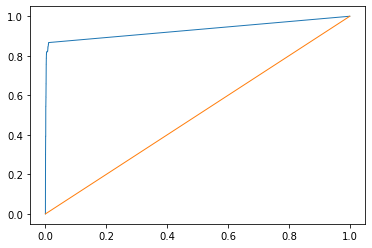

0.9315933284784452


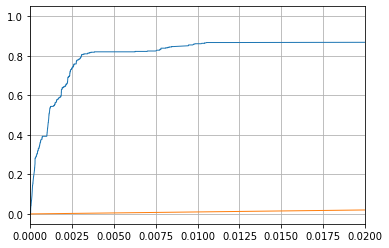

1%
fpr: 0.009997408339183939
tpr:  0.8609406952965235

421 2257593 22798 68
precision:  0.018131702485033808
recall:  0.8609406952965235
F-measure: 0.03551543782689387
MCC: 0.12411051680406873
0.5%
fpr: 0.0040778094633771135
tpr:  0.820040899795501

401 2271092 9299 88
precision:  0.04134020618556701
recall:  0.820040899795501
F-measure: 0.07871233683384041
MCC: 0.1835768688570928
0.1%
fpr: 0.000999390016887455
tpr:  0.3987730061349693

195 2278112 2279 294
precision:  0.0788197251414713
recall:  0.3987730061349693
F-measure: 0.13162335470806616
MCC: 0.17692111051407383


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization, ReLU, LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow import keras
from tensorflow.keras import layers

import itertools
import pandas as pd
import glob
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.preprocessing import scale

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

total_df = pd.read_csv("to_mrmr.csv")

window_n = 5
stride = 12
window_size = 24
normal_scores = []
feature = [
           'rec_week',
           'rec_week2', ]


df = total_df.dropna(axis=0)

normal = df[df['label']==0]
abnormal = df[df['label']==1]



total_data = total_df.dropna().loc[:, ['label'] + feature].to_numpy()

where_abnormal = np.argwhere(total_data[:,0]==1)


#assert(False)

good_score = []
bad_score = []
print(normal.shape[0])



normal_data = []

for i in range(0,total_data.shape[0]-(window_size + (window_n-1)*stride )):
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size])
  ws = np.array(ws)
  if np.all(ws[:,:,0] == 0):
    normal_data.append(ws[:, :, 1:])
  #if i == 1000:
  #  break;

normal_data = np.array(normal_data, dtype=np.float32)

print(normal_data.shape)
    
#assert(False)
#good_score.append(kl_divergence(w_p, normal_q))
abnormal_data = []

print(where_abnormal.shape)
for ab in where_abnormal:
  i = ab[0] + 1 - window_size - stride * (window_n-1)
  if (i < 0):
    continue
  ws = []
  for w_n in range(window_n):
    ws.append(total_data[(w_n*stride)+ i:(w_n*stride) + i +window_size, 1:])
  ws = np.array(ws)
  abnormal_data.append(ws)

abnormal_data = np.array(abnormal_data, dtype=np.float32)


random_idx = np.arange(normal_data.shape[0])
np.random.shuffle(random_idx)
normal_data = normal_data[random_idx]

random_idx = np.arange(abnormal_data.shape[0])
np.random.shuffle(random_idx)
abnormal_data = abnormal_data[random_idx]

cut = normal_data.shape[0]*2//10

training_x = normal_data[:cut]
training_y = [[1, 0] for _ in range(cut)]
duplicate_weight = 200

for _ in range(duplicate_weight):
  training_x = np.concatenate([training_x, abnormal_data[:abnormal_data.shape[0]//2]], axis = 0)
training_y = training_y + [[0, 1] for _ in range(training_x.shape[0]-len(training_y))]

training_y = np.array(training_y)


test_x = normal_data[cut:]
test_y = [[1, 0] for _ in range(normal_data.shape[0]-cut)]

test_x = np.concatenate([test_x, abnormal_data[abnormal_data.shape[0]//2:]], axis = 0)
test_y = test_y + [[0, 1] for _ in range(test_x.shape[0]-len(test_y))]

test_y = np.array(test_y)

print(training_x.shape)
print(training_y.shape)
print(test_x.shape)
print(test_y.shape)
 
  
def get_data():
    global training_x, training_y
    random_idx = np.arange(training_x.shape[0])
    np.random.shuffle(random_idx)
    training_x = training_x[random_idx]
    training_y = training_y[random_idx]
    for i in range(training_x.shape[0]):
      x = training_x[i].astype(np.float32)
      y = training_y[i].astype(np.int8)
      yield (x, y)

training_set = tf.data.Dataset.from_generator(get_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

training_set = training_set.batch(256)



def get_test_data():
    global test_x, test_y
    for i in range(test_x.shape[0]):
      x = test_x[i].astype(np.float32)
      y = test_y[i].astype(np.int8)
      yield (x, y)

test_set = tf.data.Dataset.from_generator(get_test_data, (tf.float32, np.int8), ((window_n, window_size, len(feature)), (2)))

test_set = test_set.batch(256)


#1층
import time

l2param=0.001

unit = 128
  
model = Sequential()

model.add(keras.Input(shape=(window_n, window_size, len(feature))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(units=unit,
              kernel_regularizer=tf.keras.regularizers.l2(l2param)
              ))
model.add(Dense(2, activation='sigmoid',
                kernel_regularizer=tf.keras.regularizers.l2(l2param)))

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0008), metrics=['accuracy'])
start = time.time()
model.fit(training_set, epochs=10, verbose=0)
end = time.time()

print("training time (sec): ", end - start)
print("training time per sample (sec): ", (end-start)/(training_x.shape[0]*10))

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

start = time.time()
result = model.predict(test_set)[:, 1]
end = time.time()

print("reference time (sec):", end-start)
print("reference time per sample (sec): ", (end-start)/test_x.shape[0])
#plt.figure()
#plt.plot(result[:100])
#plt.show()
new_label = test_y[:,1]
#new_label = 1-label
#new_label = label.astype(np.int)

#print(result[1500:1600])
#print(new_label[1500:1600])
print("="*20)
print("unit: ", unit)

fpr, tpr, thesholds = roc_curve(new_label, result)
print(thesholds)
plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print(auc(fpr, tpr))

plt.figure()
plt.plot(fpr, tpr, lw=1)

mean_fpr = np.linspace(0, 1, 100)
plt.xlim([0, 0.02])
plt.grid("on")
plt.plot(mean_fpr, mean_fpr, lw=1)
plt.show()
print("1%")
for i in range(len(fpr)):
  if fpr[i] > 0.01: #1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = np.int64(sum(np.logical_and(new_label==1,  predicted==1)))
TN = np.int64(sum(np.logical_and(new_label==0,  predicted==0)))
FP = np.int64(sum(np.logical_and(new_label==0,  predicted==1)))
FN = np.int64(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt(TP+FN)*np.sqrt(TP+FP)*np.sqrt(TN+FP)*np.sqrt(TN+FN)))

print("0.5%")
for i in range(len(fpr)):
  if fpr[i] > 0.005: #0.5%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = np.int64(sum(np.logical_and(new_label==1,  predicted==1)))
TN = np.int64(sum(np.logical_and(new_label==0,  predicted==0)))
FP = np.int64(sum(np.logical_and(new_label==0,  predicted==1)))
FN = np.int64(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt(TP+FN)*np.sqrt(TP+FP)*np.sqrt(TN+FP)*np.sqrt(TN+FN)))

print("0.1%")
for i in range(len(fpr)):
  if fpr[i] > 0.001: #0.1%
    if (i > 0): i -= 1
    break;
print("fpr:", fpr[i])
print("tpr: ",tpr[i])
print()
predicted = result >= thesholds[i]
TP = np.int64(sum(np.logical_and(new_label==1,  predicted==1)))
TN = np.int64(sum(np.logical_and(new_label==0,  predicted==0)))
FP = np.int64(sum(np.logical_and(new_label==0,  predicted==1)))
FN = np.int64(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)

print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt(TP+FN)*np.sqrt(TP+FP)*np.sqrt(TN+FP)*np.sqrt(TN+FN)))




p_plus:  0.00034236600816637446
p_minus:  0.9996576339918336
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800


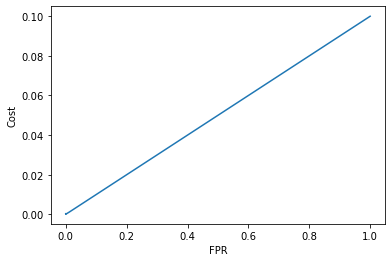

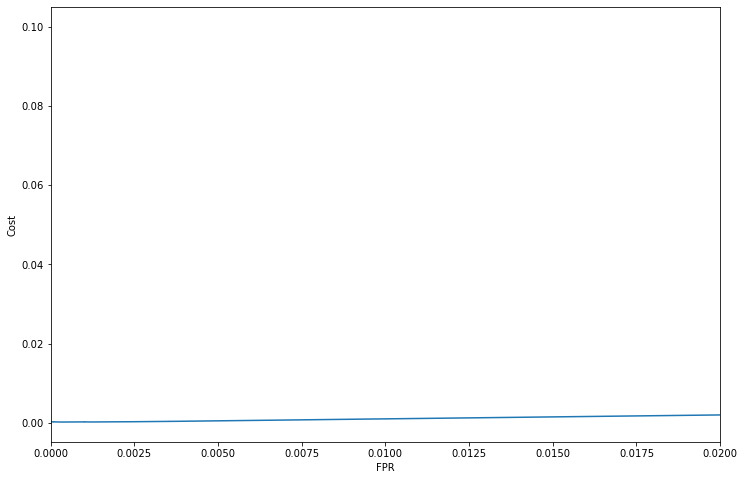

FPR at minimum cost: 0.0002916166569680375
0.0002503243238191217
138 2279726 665 351
precision:  0.1718555417185554
recall:  0.2822085889570552
F-measure: 0.2136222439749598
MCC: 0.2200128157324153


In [2]:
#총 데이터 중 정상 데이터 비율
normal_n = 2855614
#총 데이터중 비정상 데이터 비율
abnormal_n = 978

p_plus = abnormal_n/(normal_n+abnormal_n)
p_minus = normal_n/(normal_n+abnormal_n)

print("p_plus: ", p_plus)
print("p_minus: ", p_minus)
w_FNR = 0.9
w_FPR = 0.1

cost = []
for i in range(len(fpr)):
  if i % 100 == 0:
    print(i)
  predicted = result >= thesholds[i]
  TP = np.sum(np.logical_and(new_label==1,  predicted==1))
  TN = np.sum(np.logical_and(new_label==0,  predicted==0))
  FP = np.sum(np.logical_and(new_label==0,  predicted==1))
  FN = np.sum(np.logical_and(new_label==1,  predicted==0))
  FNR = FN/(FN+TP) #비정상 데이터중 미알람 비율
  FPR = FP/(FP+TN) #정상 데이터중 비정상 알람 비율
  
  cost.append(w_FNR*FNR*p_plus + w_FPR*FPR*p_minus)


plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.show()

plt.figure(figsize=[12, 8])
plt.plot(fpr, cost)
plt.xlabel("FPR")
plt.ylabel("Cost")
plt.xlim([0, 0.02])
#plt.ylim([0, cost[400]])
plt.show()

print("FPR at minimum cost:", fpr[np.argmin(cost)])
print(np.amin(cost))

i = np.argmin(cost)
predicted = result >= thesholds[i]
TP = int(sum(np.logical_and(new_label==1,  predicted==1)))
TN = int(sum(np.logical_and(new_label==0,  predicted==0)))
FP = int(sum(np.logical_and(new_label==0,  predicted==1)))
FN = int(sum(np.logical_and(new_label==1,  predicted==0)))

print(TP,TN,FP,FN)

Precision = TP/(TP+FP)
Recall = TP/(TP+FN)


print("precision: ", Precision)
print("recall: ", Recall)
print("F-measure:", (2*Precision*Recall)/(Precision+Recall+1e-7))
print("MCC:", (TP*TN-FP*FN)/(np.sqrt((TP+FN)*(TP+FP)*(TN+FP)*(TN+FN)*1.0))+1e-7)